## GAN generator for MNIST
### Author: Karim Choukri
Email: kchoukri@gmail.com

Date: 06/10/2019

Release: 1.10

In [9]:

import sys
import numpy as np
import pandas as pd
from IPython.core.debugger import Tracer
from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers import BatchNormalization
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Sequential, Model
from keras.optimizers import Adam, RMSprop
import matplotlib.pyplot as plt
plt.switch_backend('agg')

In [2]:
def plot_model_perf_fromframe(frame1,frame2, fig = 1):

    # summarize history for accuracy
    plt.figure(fig)
    plt.plot(frame1['acc'])
    plt.plot(frame2['acc'])
    plt.title('models accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['Discriminator', 'GAN'], loc='upper left')
    plt.grid(True)
    plt.show()
    
    # summarize history for loss
    plt.figure(fig+1)
    plt.plot(frame1['loss'])
    plt.plot(frame2['loss'])
    plt.title('models loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['Discriminator', 'GAN'], loc='upper left')
    plt.grid(True)
    plt.show()

    return()

In [5]:
class GAN(object):
    def __init__(self, width = 28, height= 28, channels = 1):
        self.WIDTH = width
        self.HEIGHT = height
        self.CHANNELS = channels
        self.SHAPE = (self.WIDTH, self.HEIGHT, self.CHANNELS)
        self.OPTIMIZER = Adam(lr=0.0002, decay=8e-9)
        self.noise_gen = np.random.normal(0,1,(100,))
        
        self.G = self.generator()
        self.G.compile(loss='binary_crossentropy', optimizer=self.OPTIMIZER)
        
        self.D = self.discriminator()
        self.D.compile(loss='binary_crossentropy', optimizer=self.OPTIMIZER, metrics=['accuracy'] )
        
        self.stacked_G_D = self.stacked_G_D()
        self.stacked_G_D.compile(loss='binary_crossentropy', optimizer=self.OPTIMIZER, metrics=['accuracy'])
        
    def generator(self):
        model = Sequential()
        model.add(Dense(256, input_shape=(100,)))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(1024))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(self.WIDTH * self.HEIGHT * self.CHANNELS, activation='tanh'))
        model.add(Reshape((self.WIDTH, self.HEIGHT, self.CHANNELS)))
        
        return model
    
    def discriminator(self):
        model = Sequential()
        model.add(Flatten(input_shape=self.SHAPE))
        model.add(Dense((self.WIDTH * self.HEIGHT * self.CHANNELS), input_shape=self.SHAPE))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(int((self.WIDTH * self.HEIGHT * self.CHANNELS)/2)))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(1, activation='sigmoid'))
        model.summary()
        return model
    
    def stacked_G_D(self):
        self.D.trainable = False
        model = Sequential()
        model.add(self.G)
        model.add(self.D)
        return model
    
    def train(self, X_train, epochs=10000, batch = 32, save_interval = 200, verbose = True):
        
        hist_D = list()
        hist_GAN = list()
        
        for cnt in range(epochs):
        ## train discriminator
            random_index =  np.random.randint(0, len(X_train) - int(batch/2))
            legit_images = X_train[random_index : random_index + int(batch/2)].reshape(int(batch/2), self.WIDTH, 
                                                                                  self.HEIGHT, self.CHANNELS)
            gen_noise = np.random.normal(0, 1, (int(batch/2),100))
            syntetic_images = self.G.predict(gen_noise)
            x_combined_batch = np.concatenate((legit_images, syntetic_images))
            y_combined_batch = np.concatenate((np.ones((int(batch/2), 1)), np.zeros((int(batch/2), 1))))
            d_loss = self.D.train_on_batch(x_combined_batch, y_combined_batch)
            hist_D.append(d_loss)

        # train generator
            noise = np.random.normal(0, 1, (batch,100))
            y_mislabled = np.ones((batch, 1))
            g_loss = self.stacked_G_D.train_on_batch(noise, y_mislabled)
            print ('epoch: %d, [Discriminator :: d_loss: %f], [ Generator :: loss: %f]' % (cnt, d_loss[0], g_loss[0] ))
            hist_GAN.append(g_loss)
            
            if cnt % save_interval == 0 : 
                self.plot_images(save2file=True, step=cnt)

        if verbose == True:
            self.plot_perf(hist_D, hist_GAN, verbose, save2file=False)
    
    def plot_images(self, save2file=False,  samples=16, step=0):
        filename = "./images/mnist_%d.png" % step
        noise = np.random.normal(0, 1, (samples,100))
        images = self.G.predict(noise)
        
        plt.figure(figsize=(10,10))
    
        for i in range(images.shape[0]):
            plt.subplot(4, 4, i+1)
            image = images[i, :, :, :]
            image = np.reshape(image, [ self.HEIGHT, self.WIDTH ])
            plt.imshow(image, cmap='gray')
            plt.axis('off')
            plt.tight_layout()
        if save2file:
            plt.savefig(filename)
            plt.close('all')
        else:
            plt.show()
    
    def plot_perf(self, hist_d, hist_gan, verbose, save2file=False):
        filename = "./images/EuroM_GAN_perf.png"
        
        frame_D = pd.DataFrame(np.zeros((len(hist_d),3)), columns = ['iter', 'loss','acc'] )
        frame_gan = pd.DataFrame(np.zeros((len(hist_gan),3)), columns = ['iter', 'loss','acc'] )


        for i in range(len(hist_gan)):
            frame_D.iter.iloc[i] = int(i)
            frame_D.loss.iloc[i] = hist_d[i][0]
            frame_D.acc.iloc[i] = hist_d[i][1]
            
            frame_gan.iter.iloc[i] = int(i)
            frame_gan.loss.iloc[i] = hist_gan[i][0]
            frame_gan.acc.iloc[i] = hist_gan[i][1]
            
        if verbose == True:
            fig = 1
            plot_model_perf_fromframe(frame_D,frame_gan,fig)
            
        if save2file:
            plt.savefig(filename)
            plt.close('all')
        
        self.history_D = frame_D
        self.history_GAN = frame_gan
    

In [10]:
(X_train, _), (_, _) = mnist.load_data()
# Rescale -1 to 1
X_train = (X_train.astype(np.float32) - 127.5) / 127.5
X_train = np.expand_dims(X_train, axis=3)
gan = GAN()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 784)               615440    
_________________________________________________________________
leaky_re_lu_9 (LeakyReLU)    (None, 784)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 392)               307720    
_________________________________________________________________
leaky_re_lu_10 (LeakyReLU)   (None, 392)               0         
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 393       
Total params: 923,553
Trainable params: 923,553
Non-trainable params: 0
_________________________________________________________________


In [11]:
X_train.shape

(60000, 28, 28, 1)

epoch: 0, [Discriminator :: d_loss: 0.610582], [ Generator :: loss: 0.526552]
epoch: 1, [Discriminator :: d_loss: 0.536371], [ Generator :: loss: 0.568275]
epoch: 2, [Discriminator :: d_loss: 0.521959], [ Generator :: loss: 0.635136]
epoch: 3, [Discriminator :: d_loss: 0.366559], [ Generator :: loss: 0.737822]
epoch: 4, [Discriminator :: d_loss: 0.343149], [ Generator :: loss: 0.857705]
epoch: 5, [Discriminator :: d_loss: 0.314046], [ Generator :: loss: 0.959179]
epoch: 6, [Discriminator :: d_loss: 0.260483], [ Generator :: loss: 1.165988]
epoch: 7, [Discriminator :: d_loss: 0.249257], [ Generator :: loss: 1.417119]
epoch: 8, [Discriminator :: d_loss: 0.187472], [ Generator :: loss: 1.597675]
epoch: 9, [Discriminator :: d_loss: 0.146249], [ Generator :: loss: 1.862426]
epoch: 10, [Discriminator :: d_loss: 0.116036], [ Generator :: loss: 2.097724]
epoch: 11, [Discriminator :: d_loss: 0.078917], [ Generator :: loss: 2.314969]
epoch: 12, [Discriminator :: d_loss: 0.060273], [ Generator ::

epoch: 107, [Discriminator :: d_loss: 0.007371], [ Generator :: loss: 5.053594]
epoch: 108, [Discriminator :: d_loss: 0.003764], [ Generator :: loss: 4.983604]
epoch: 109, [Discriminator :: d_loss: 0.006155], [ Generator :: loss: 5.235670]
epoch: 110, [Discriminator :: d_loss: 0.008227], [ Generator :: loss: 4.970545]
epoch: 111, [Discriminator :: d_loss: 0.004361], [ Generator :: loss: 4.981727]
epoch: 112, [Discriminator :: d_loss: 0.004742], [ Generator :: loss: 5.002300]
epoch: 113, [Discriminator :: d_loss: 0.014632], [ Generator :: loss: 4.922405]
epoch: 114, [Discriminator :: d_loss: 0.006543], [ Generator :: loss: 4.978541]
epoch: 115, [Discriminator :: d_loss: 0.008013], [ Generator :: loss: 4.988168]
epoch: 116, [Discriminator :: d_loss: 0.005686], [ Generator :: loss: 5.084254]
epoch: 117, [Discriminator :: d_loss: 0.005408], [ Generator :: loss: 5.143212]
epoch: 118, [Discriminator :: d_loss: 0.006636], [ Generator :: loss: 5.131033]
epoch: 119, [Discriminator :: d_loss: 0.

epoch: 210, [Discriminator :: d_loss: 0.239188], [ Generator :: loss: 3.941587]
epoch: 211, [Discriminator :: d_loss: 0.318781], [ Generator :: loss: 3.920452]
epoch: 212, [Discriminator :: d_loss: 0.093143], [ Generator :: loss: 3.941829]
epoch: 213, [Discriminator :: d_loss: 0.177932], [ Generator :: loss: 3.500753]
epoch: 214, [Discriminator :: d_loss: 0.167826], [ Generator :: loss: 3.302839]
epoch: 215, [Discriminator :: d_loss: 0.185639], [ Generator :: loss: 3.371019]
epoch: 216, [Discriminator :: d_loss: 0.365626], [ Generator :: loss: 4.460044]
epoch: 217, [Discriminator :: d_loss: 0.370221], [ Generator :: loss: 4.018995]
epoch: 218, [Discriminator :: d_loss: 0.329915], [ Generator :: loss: 3.841479]
epoch: 219, [Discriminator :: d_loss: 0.323928], [ Generator :: loss: 3.629075]
epoch: 220, [Discriminator :: d_loss: 0.325959], [ Generator :: loss: 4.013622]
epoch: 221, [Discriminator :: d_loss: 0.195970], [ Generator :: loss: 4.631671]
epoch: 222, [Discriminator :: d_loss: 0.

epoch: 313, [Discriminator :: d_loss: 0.018031], [ Generator :: loss: 7.226938]
epoch: 314, [Discriminator :: d_loss: 0.037145], [ Generator :: loss: 6.773824]
epoch: 315, [Discriminator :: d_loss: 0.090543], [ Generator :: loss: 7.268916]
epoch: 316, [Discriminator :: d_loss: 0.022349], [ Generator :: loss: 6.384956]
epoch: 317, [Discriminator :: d_loss: 0.027089], [ Generator :: loss: 6.424368]
epoch: 318, [Discriminator :: d_loss: 0.025187], [ Generator :: loss: 6.949204]
epoch: 319, [Discriminator :: d_loss: 0.013405], [ Generator :: loss: 7.229645]
epoch: 320, [Discriminator :: d_loss: 0.034896], [ Generator :: loss: 7.270509]
epoch: 321, [Discriminator :: d_loss: 0.098977], [ Generator :: loss: 7.031127]
epoch: 322, [Discriminator :: d_loss: 0.013548], [ Generator :: loss: 7.657452]
epoch: 323, [Discriminator :: d_loss: 0.077189], [ Generator :: loss: 7.681770]
epoch: 324, [Discriminator :: d_loss: 0.029679], [ Generator :: loss: 7.385054]
epoch: 325, [Discriminator :: d_loss: 0.

epoch: 416, [Discriminator :: d_loss: 0.055954], [ Generator :: loss: 7.497106]
epoch: 417, [Discriminator :: d_loss: 0.068888], [ Generator :: loss: 6.853551]
epoch: 418, [Discriminator :: d_loss: 0.125100], [ Generator :: loss: 6.178898]
epoch: 419, [Discriminator :: d_loss: 0.240358], [ Generator :: loss: 6.024841]
epoch: 420, [Discriminator :: d_loss: 0.070794], [ Generator :: loss: 5.820816]
epoch: 421, [Discriminator :: d_loss: 0.050299], [ Generator :: loss: 6.383723]
epoch: 422, [Discriminator :: d_loss: 0.040143], [ Generator :: loss: 6.651563]
epoch: 423, [Discriminator :: d_loss: 0.057912], [ Generator :: loss: 6.216316]
epoch: 424, [Discriminator :: d_loss: 0.047056], [ Generator :: loss: 6.788257]
epoch: 425, [Discriminator :: d_loss: 0.093677], [ Generator :: loss: 7.423145]
epoch: 426, [Discriminator :: d_loss: 0.062261], [ Generator :: loss: 7.052903]
epoch: 427, [Discriminator :: d_loss: 0.063087], [ Generator :: loss: 6.688050]
epoch: 428, [Discriminator :: d_loss: 0.

epoch: 521, [Discriminator :: d_loss: 0.164420], [ Generator :: loss: 4.538948]
epoch: 522, [Discriminator :: d_loss: 0.089566], [ Generator :: loss: 4.310972]
epoch: 523, [Discriminator :: d_loss: 0.135017], [ Generator :: loss: 5.023952]
epoch: 524, [Discriminator :: d_loss: 0.080084], [ Generator :: loss: 6.158531]
epoch: 525, [Discriminator :: d_loss: 0.246889], [ Generator :: loss: 6.879051]
epoch: 526, [Discriminator :: d_loss: 0.249394], [ Generator :: loss: 4.927721]
epoch: 527, [Discriminator :: d_loss: 0.342098], [ Generator :: loss: 3.703024]
epoch: 528, [Discriminator :: d_loss: 0.346646], [ Generator :: loss: 4.891621]
epoch: 529, [Discriminator :: d_loss: 0.276322], [ Generator :: loss: 7.651280]
epoch: 530, [Discriminator :: d_loss: 0.346579], [ Generator :: loss: 6.715378]
epoch: 531, [Discriminator :: d_loss: 0.338181], [ Generator :: loss: 3.528599]
epoch: 532, [Discriminator :: d_loss: 0.329491], [ Generator :: loss: 3.299675]
epoch: 533, [Discriminator :: d_loss: 0.

epoch: 624, [Discriminator :: d_loss: 0.118908], [ Generator :: loss: 6.032047]
epoch: 625, [Discriminator :: d_loss: 0.083867], [ Generator :: loss: 4.325644]
epoch: 626, [Discriminator :: d_loss: 0.161121], [ Generator :: loss: 3.451072]
epoch: 627, [Discriminator :: d_loss: 0.283286], [ Generator :: loss: 3.070817]
epoch: 628, [Discriminator :: d_loss: 0.309933], [ Generator :: loss: 5.419786]
epoch: 629, [Discriminator :: d_loss: 0.139765], [ Generator :: loss: 7.661104]
epoch: 630, [Discriminator :: d_loss: 0.725356], [ Generator :: loss: 4.649160]
epoch: 631, [Discriminator :: d_loss: 0.198395], [ Generator :: loss: 2.352464]
epoch: 632, [Discriminator :: d_loss: 0.585489], [ Generator :: loss: 2.629946]
epoch: 633, [Discriminator :: d_loss: 0.347541], [ Generator :: loss: 4.958270]
epoch: 634, [Discriminator :: d_loss: 0.089154], [ Generator :: loss: 7.463958]
epoch: 635, [Discriminator :: d_loss: 0.266545], [ Generator :: loss: 7.703498]
epoch: 636, [Discriminator :: d_loss: 0.

epoch: 731, [Discriminator :: d_loss: 0.241807], [ Generator :: loss: 3.910037]
epoch: 732, [Discriminator :: d_loss: 0.212244], [ Generator :: loss: 3.348364]
epoch: 733, [Discriminator :: d_loss: 0.261276], [ Generator :: loss: 3.767131]
epoch: 734, [Discriminator :: d_loss: 0.200648], [ Generator :: loss: 3.399444]
epoch: 735, [Discriminator :: d_loss: 0.418487], [ Generator :: loss: 3.409912]
epoch: 736, [Discriminator :: d_loss: 0.168338], [ Generator :: loss: 3.807497]
epoch: 737, [Discriminator :: d_loss: 0.339293], [ Generator :: loss: 3.637664]
epoch: 738, [Discriminator :: d_loss: 0.119613], [ Generator :: loss: 3.084164]
epoch: 739, [Discriminator :: d_loss: 0.233943], [ Generator :: loss: 3.642914]
epoch: 740, [Discriminator :: d_loss: 0.206113], [ Generator :: loss: 4.430814]
epoch: 741, [Discriminator :: d_loss: 0.503478], [ Generator :: loss: 2.721136]
epoch: 742, [Discriminator :: d_loss: 0.224627], [ Generator :: loss: 2.897710]
epoch: 743, [Discriminator :: d_loss: 0.

epoch: 837, [Discriminator :: d_loss: 0.380771], [ Generator :: loss: 3.943198]
epoch: 838, [Discriminator :: d_loss: 0.116325], [ Generator :: loss: 2.619065]
epoch: 839, [Discriminator :: d_loss: 0.346375], [ Generator :: loss: 1.671644]
epoch: 840, [Discriminator :: d_loss: 0.443180], [ Generator :: loss: 3.240454]
epoch: 841, [Discriminator :: d_loss: 0.287875], [ Generator :: loss: 4.097643]
epoch: 842, [Discriminator :: d_loss: 0.128192], [ Generator :: loss: 3.433407]
epoch: 843, [Discriminator :: d_loss: 0.161326], [ Generator :: loss: 3.084397]
epoch: 844, [Discriminator :: d_loss: 0.183889], [ Generator :: loss: 3.553537]
epoch: 845, [Discriminator :: d_loss: 0.102973], [ Generator :: loss: 3.576295]
epoch: 846, [Discriminator :: d_loss: 0.088687], [ Generator :: loss: 3.508004]
epoch: 847, [Discriminator :: d_loss: 0.359579], [ Generator :: loss: 4.283710]
epoch: 848, [Discriminator :: d_loss: 0.224319], [ Generator :: loss: 3.765216]
epoch: 849, [Discriminator :: d_loss: 0.

epoch: 941, [Discriminator :: d_loss: 0.178811], [ Generator :: loss: 4.916459]
epoch: 942, [Discriminator :: d_loss: 0.154329], [ Generator :: loss: 5.323948]
epoch: 943, [Discriminator :: d_loss: 0.211243], [ Generator :: loss: 4.719331]
epoch: 944, [Discriminator :: d_loss: 0.166140], [ Generator :: loss: 3.539697]
epoch: 945, [Discriminator :: d_loss: 0.211663], [ Generator :: loss: 3.248329]
epoch: 946, [Discriminator :: d_loss: 0.122818], [ Generator :: loss: 3.606611]
epoch: 947, [Discriminator :: d_loss: 0.161244], [ Generator :: loss: 4.204861]
epoch: 948, [Discriminator :: d_loss: 0.178207], [ Generator :: loss: 3.323289]
epoch: 949, [Discriminator :: d_loss: 0.143175], [ Generator :: loss: 3.172662]
epoch: 950, [Discriminator :: d_loss: 0.152758], [ Generator :: loss: 3.160049]
epoch: 951, [Discriminator :: d_loss: 0.229266], [ Generator :: loss: 2.498222]
epoch: 952, [Discriminator :: d_loss: 0.224280], [ Generator :: loss: 3.078368]
epoch: 953, [Discriminator :: d_loss: 0.

epoch: 1044, [Discriminator :: d_loss: 0.132454], [ Generator :: loss: 5.027753]
epoch: 1045, [Discriminator :: d_loss: 0.098049], [ Generator :: loss: 4.893089]
epoch: 1046, [Discriminator :: d_loss: 0.256529], [ Generator :: loss: 3.878017]
epoch: 1047, [Discriminator :: d_loss: 0.213558], [ Generator :: loss: 3.284107]
epoch: 1048, [Discriminator :: d_loss: 0.163803], [ Generator :: loss: 3.151985]
epoch: 1049, [Discriminator :: d_loss: 0.087908], [ Generator :: loss: 3.348080]
epoch: 1050, [Discriminator :: d_loss: 0.100411], [ Generator :: loss: 3.007821]
epoch: 1051, [Discriminator :: d_loss: 0.138847], [ Generator :: loss: 3.021694]
epoch: 1052, [Discriminator :: d_loss: 0.186650], [ Generator :: loss: 3.530594]
epoch: 1053, [Discriminator :: d_loss: 0.226999], [ Generator :: loss: 3.791310]
epoch: 1054, [Discriminator :: d_loss: 0.219056], [ Generator :: loss: 3.078587]
epoch: 1055, [Discriminator :: d_loss: 0.143996], [ Generator :: loss: 3.637217]
epoch: 1056, [Discriminator 

epoch: 1148, [Discriminator :: d_loss: 0.288952], [ Generator :: loss: 3.001539]
epoch: 1149, [Discriminator :: d_loss: 0.211207], [ Generator :: loss: 3.275741]
epoch: 1150, [Discriminator :: d_loss: 0.399114], [ Generator :: loss: 2.061748]
epoch: 1151, [Discriminator :: d_loss: 0.256984], [ Generator :: loss: 1.972571]
epoch: 1152, [Discriminator :: d_loss: 0.448900], [ Generator :: loss: 3.080580]
epoch: 1153, [Discriminator :: d_loss: 0.174868], [ Generator :: loss: 4.573704]
epoch: 1154, [Discriminator :: d_loss: 0.473403], [ Generator :: loss: 3.331148]
epoch: 1155, [Discriminator :: d_loss: 0.202062], [ Generator :: loss: 2.316137]
epoch: 1156, [Discriminator :: d_loss: 0.273199], [ Generator :: loss: 1.767834]
epoch: 1157, [Discriminator :: d_loss: 0.396623], [ Generator :: loss: 2.685614]
epoch: 1158, [Discriminator :: d_loss: 0.319893], [ Generator :: loss: 4.503516]
epoch: 1159, [Discriminator :: d_loss: 0.405941], [ Generator :: loss: 3.513877]
epoch: 1160, [Discriminator 

epoch: 1252, [Discriminator :: d_loss: 0.168205], [ Generator :: loss: 3.724597]
epoch: 1253, [Discriminator :: d_loss: 0.201193], [ Generator :: loss: 2.148303]
epoch: 1254, [Discriminator :: d_loss: 0.365100], [ Generator :: loss: 2.094008]
epoch: 1255, [Discriminator :: d_loss: 0.539073], [ Generator :: loss: 1.944895]
epoch: 1256, [Discriminator :: d_loss: 0.234297], [ Generator :: loss: 2.775210]
epoch: 1257, [Discriminator :: d_loss: 0.400516], [ Generator :: loss: 4.178947]
epoch: 1258, [Discriminator :: d_loss: 0.434936], [ Generator :: loss: 3.165045]
epoch: 1259, [Discriminator :: d_loss: 0.303650], [ Generator :: loss: 1.877653]
epoch: 1260, [Discriminator :: d_loss: 0.526239], [ Generator :: loss: 1.702358]
epoch: 1261, [Discriminator :: d_loss: 0.178485], [ Generator :: loss: 3.290404]
epoch: 1262, [Discriminator :: d_loss: 0.237720], [ Generator :: loss: 4.990896]
epoch: 1263, [Discriminator :: d_loss: 0.361775], [ Generator :: loss: 3.585784]
epoch: 1264, [Discriminator 

epoch: 1356, [Discriminator :: d_loss: 0.340444], [ Generator :: loss: 2.232058]
epoch: 1357, [Discriminator :: d_loss: 0.299224], [ Generator :: loss: 3.460010]
epoch: 1358, [Discriminator :: d_loss: 0.285058], [ Generator :: loss: 3.491757]
epoch: 1359, [Discriminator :: d_loss: 0.283245], [ Generator :: loss: 3.781051]
epoch: 1360, [Discriminator :: d_loss: 0.319986], [ Generator :: loss: 2.491873]
epoch: 1361, [Discriminator :: d_loss: 0.229994], [ Generator :: loss: 2.456921]
epoch: 1362, [Discriminator :: d_loss: 0.173961], [ Generator :: loss: 3.643993]
epoch: 1363, [Discriminator :: d_loss: 0.368440], [ Generator :: loss: 4.588358]
epoch: 1364, [Discriminator :: d_loss: 0.230156], [ Generator :: loss: 2.738258]
epoch: 1365, [Discriminator :: d_loss: 0.285058], [ Generator :: loss: 2.484485]
epoch: 1366, [Discriminator :: d_loss: 0.277824], [ Generator :: loss: 2.873208]
epoch: 1367, [Discriminator :: d_loss: 0.255600], [ Generator :: loss: 3.759136]
epoch: 1368, [Discriminator 

epoch: 1462, [Discriminator :: d_loss: 0.219879], [ Generator :: loss: 2.580281]
epoch: 1463, [Discriminator :: d_loss: 0.371140], [ Generator :: loss: 2.398535]
epoch: 1464, [Discriminator :: d_loss: 0.244980], [ Generator :: loss: 3.626503]
epoch: 1465, [Discriminator :: d_loss: 0.235250], [ Generator :: loss: 4.139931]
epoch: 1466, [Discriminator :: d_loss: 0.414262], [ Generator :: loss: 2.311303]
epoch: 1467, [Discriminator :: d_loss: 0.303345], [ Generator :: loss: 1.792158]
epoch: 1468, [Discriminator :: d_loss: 0.476599], [ Generator :: loss: 3.310110]
epoch: 1469, [Discriminator :: d_loss: 0.139927], [ Generator :: loss: 5.229379]
epoch: 1470, [Discriminator :: d_loss: 0.603541], [ Generator :: loss: 3.519533]
epoch: 1471, [Discriminator :: d_loss: 0.495403], [ Generator :: loss: 2.096908]
epoch: 1472, [Discriminator :: d_loss: 0.363747], [ Generator :: loss: 1.805945]
epoch: 1473, [Discriminator :: d_loss: 0.318342], [ Generator :: loss: 3.481475]
epoch: 1474, [Discriminator 

epoch: 1668, [Discriminator :: d_loss: 0.384726], [ Generator :: loss: 2.443148]
epoch: 1669, [Discriminator :: d_loss: 0.245358], [ Generator :: loss: 5.729167]
epoch: 1670, [Discriminator :: d_loss: 0.479208], [ Generator :: loss: 4.832037]
epoch: 1671, [Discriminator :: d_loss: 0.557026], [ Generator :: loss: 1.906642]
epoch: 1672, [Discriminator :: d_loss: 0.269368], [ Generator :: loss: 0.947063]
epoch: 1673, [Discriminator :: d_loss: 0.734053], [ Generator :: loss: 1.675846]
epoch: 1674, [Discriminator :: d_loss: 0.560542], [ Generator :: loss: 5.285946]
epoch: 1675, [Discriminator :: d_loss: 0.361111], [ Generator :: loss: 6.296628]
epoch: 1676, [Discriminator :: d_loss: 0.586536], [ Generator :: loss: 5.104502]
epoch: 1677, [Discriminator :: d_loss: 0.519977], [ Generator :: loss: 1.169729]
epoch: 1678, [Discriminator :: d_loss: 0.406347], [ Generator :: loss: 0.998062]
epoch: 1679, [Discriminator :: d_loss: 0.702274], [ Generator :: loss: 1.868865]
epoch: 1680, [Discriminator 

epoch: 1772, [Discriminator :: d_loss: 0.327062], [ Generator :: loss: 2.675717]
epoch: 1773, [Discriminator :: d_loss: 0.226452], [ Generator :: loss: 3.522464]
epoch: 1774, [Discriminator :: d_loss: 0.667664], [ Generator :: loss: 2.340271]
epoch: 1775, [Discriminator :: d_loss: 0.301929], [ Generator :: loss: 1.291950]
epoch: 1776, [Discriminator :: d_loss: 0.464567], [ Generator :: loss: 1.519898]
epoch: 1777, [Discriminator :: d_loss: 0.517794], [ Generator :: loss: 2.624936]
epoch: 1778, [Discriminator :: d_loss: 0.322524], [ Generator :: loss: 3.492738]
epoch: 1779, [Discriminator :: d_loss: 0.413784], [ Generator :: loss: 2.251498]
epoch: 1780, [Discriminator :: d_loss: 0.256557], [ Generator :: loss: 1.762356]
epoch: 1781, [Discriminator :: d_loss: 0.445360], [ Generator :: loss: 2.148135]
epoch: 1782, [Discriminator :: d_loss: 0.419927], [ Generator :: loss: 2.741993]
epoch: 1783, [Discriminator :: d_loss: 0.401243], [ Generator :: loss: 2.857474]
epoch: 1784, [Discriminator 

epoch: 1874, [Discriminator :: d_loss: 0.443543], [ Generator :: loss: 3.660783]
epoch: 1875, [Discriminator :: d_loss: 0.623417], [ Generator :: loss: 3.703019]
epoch: 1876, [Discriminator :: d_loss: 0.332968], [ Generator :: loss: 3.026736]
epoch: 1877, [Discriminator :: d_loss: 0.461235], [ Generator :: loss: 1.584841]
epoch: 1878, [Discriminator :: d_loss: 0.378491], [ Generator :: loss: 1.583272]
epoch: 1879, [Discriminator :: d_loss: 0.382722], [ Generator :: loss: 1.727541]
epoch: 1880, [Discriminator :: d_loss: 0.419901], [ Generator :: loss: 2.512014]
epoch: 1881, [Discriminator :: d_loss: 0.314000], [ Generator :: loss: 2.527715]
epoch: 1882, [Discriminator :: d_loss: 0.231198], [ Generator :: loss: 2.121645]
epoch: 1883, [Discriminator :: d_loss: 0.302176], [ Generator :: loss: 2.317022]
epoch: 1884, [Discriminator :: d_loss: 0.615857], [ Generator :: loss: 1.975278]
epoch: 1885, [Discriminator :: d_loss: 0.410399], [ Generator :: loss: 1.818150]
epoch: 1886, [Discriminator 

epoch: 1976, [Discriminator :: d_loss: 0.348896], [ Generator :: loss: 3.690804]
epoch: 1977, [Discriminator :: d_loss: 0.525338], [ Generator :: loss: 2.454078]
epoch: 1978, [Discriminator :: d_loss: 0.398008], [ Generator :: loss: 0.935807]
epoch: 1979, [Discriminator :: d_loss: 0.543709], [ Generator :: loss: 0.924062]
epoch: 1980, [Discriminator :: d_loss: 0.464035], [ Generator :: loss: 1.788494]
epoch: 1981, [Discriminator :: d_loss: 0.337346], [ Generator :: loss: 3.023735]
epoch: 1982, [Discriminator :: d_loss: 0.417713], [ Generator :: loss: 3.645194]
epoch: 1983, [Discriminator :: d_loss: 0.674188], [ Generator :: loss: 2.402783]
epoch: 1984, [Discriminator :: d_loss: 0.516881], [ Generator :: loss: 1.359763]
epoch: 1985, [Discriminator :: d_loss: 0.354579], [ Generator :: loss: 1.227385]
epoch: 1986, [Discriminator :: d_loss: 0.543326], [ Generator :: loss: 1.496255]
epoch: 1987, [Discriminator :: d_loss: 0.272688], [ Generator :: loss: 2.228971]
epoch: 1988, [Discriminator 

epoch: 2080, [Discriminator :: d_loss: 0.274007], [ Generator :: loss: 3.146865]
epoch: 2081, [Discriminator :: d_loss: 0.449549], [ Generator :: loss: 2.982932]
epoch: 2082, [Discriminator :: d_loss: 0.766740], [ Generator :: loss: 1.876635]
epoch: 2083, [Discriminator :: d_loss: 0.680289], [ Generator :: loss: 1.121918]
epoch: 2084, [Discriminator :: d_loss: 0.692177], [ Generator :: loss: 1.726953]
epoch: 2085, [Discriminator :: d_loss: 0.416646], [ Generator :: loss: 2.473805]
epoch: 2086, [Discriminator :: d_loss: 0.360686], [ Generator :: loss: 3.589318]
epoch: 2087, [Discriminator :: d_loss: 0.638893], [ Generator :: loss: 3.567727]
epoch: 2088, [Discriminator :: d_loss: 0.742557], [ Generator :: loss: 1.809631]
epoch: 2089, [Discriminator :: d_loss: 0.402568], [ Generator :: loss: 1.110995]
epoch: 2090, [Discriminator :: d_loss: 0.451101], [ Generator :: loss: 1.285502]
epoch: 2091, [Discriminator :: d_loss: 0.389847], [ Generator :: loss: 1.803331]
epoch: 2092, [Discriminator 

epoch: 2182, [Discriminator :: d_loss: 0.785362], [ Generator :: loss: 1.285648]
epoch: 2183, [Discriminator :: d_loss: 0.505470], [ Generator :: loss: 2.032776]
epoch: 2184, [Discriminator :: d_loss: 0.421796], [ Generator :: loss: 3.494119]
epoch: 2185, [Discriminator :: d_loss: 0.445504], [ Generator :: loss: 4.060023]
epoch: 2186, [Discriminator :: d_loss: 1.056501], [ Generator :: loss: 2.154436]
epoch: 2187, [Discriminator :: d_loss: 0.537568], [ Generator :: loss: 0.742918]
epoch: 2188, [Discriminator :: d_loss: 0.679389], [ Generator :: loss: 1.139074]
epoch: 2189, [Discriminator :: d_loss: 0.950009], [ Generator :: loss: 1.920631]
epoch: 2190, [Discriminator :: d_loss: 0.380874], [ Generator :: loss: 3.151103]
epoch: 2191, [Discriminator :: d_loss: 0.621701], [ Generator :: loss: 3.966148]
epoch: 2192, [Discriminator :: d_loss: 0.877483], [ Generator :: loss: 2.286432]
epoch: 2193, [Discriminator :: d_loss: 0.393966], [ Generator :: loss: 1.228284]
epoch: 2194, [Discriminator 

epoch: 2286, [Discriminator :: d_loss: 0.541727], [ Generator :: loss: 1.678857]
epoch: 2287, [Discriminator :: d_loss: 0.263194], [ Generator :: loss: 1.489406]
epoch: 2288, [Discriminator :: d_loss: 0.309393], [ Generator :: loss: 1.750892]
epoch: 2289, [Discriminator :: d_loss: 0.279260], [ Generator :: loss: 2.326354]
epoch: 2290, [Discriminator :: d_loss: 0.312571], [ Generator :: loss: 2.362074]
epoch: 2291, [Discriminator :: d_loss: 0.473385], [ Generator :: loss: 1.754933]
epoch: 2292, [Discriminator :: d_loss: 0.352491], [ Generator :: loss: 1.845691]
epoch: 2293, [Discriminator :: d_loss: 0.348867], [ Generator :: loss: 2.051421]
epoch: 2294, [Discriminator :: d_loss: 0.302782], [ Generator :: loss: 1.880115]
epoch: 2295, [Discriminator :: d_loss: 0.322559], [ Generator :: loss: 1.496166]
epoch: 2296, [Discriminator :: d_loss: 0.215286], [ Generator :: loss: 1.403724]
epoch: 2297, [Discriminator :: d_loss: 0.409416], [ Generator :: loss: 1.499538]
epoch: 2298, [Discriminator 

epoch: 2390, [Discriminator :: d_loss: 0.371510], [ Generator :: loss: 1.642268]
epoch: 2391, [Discriminator :: d_loss: 0.404096], [ Generator :: loss: 1.823056]
epoch: 2392, [Discriminator :: d_loss: 0.537434], [ Generator :: loss: 2.062116]
epoch: 2393, [Discriminator :: d_loss: 0.471686], [ Generator :: loss: 2.143798]
epoch: 2394, [Discriminator :: d_loss: 0.401862], [ Generator :: loss: 2.406552]
epoch: 2395, [Discriminator :: d_loss: 0.395281], [ Generator :: loss: 2.038595]
epoch: 2396, [Discriminator :: d_loss: 0.402761], [ Generator :: loss: 2.112941]
epoch: 2397, [Discriminator :: d_loss: 0.278023], [ Generator :: loss: 1.599708]
epoch: 2398, [Discriminator :: d_loss: 0.548832], [ Generator :: loss: 1.621462]
epoch: 2399, [Discriminator :: d_loss: 0.399311], [ Generator :: loss: 2.027988]
epoch: 2400, [Discriminator :: d_loss: 0.284916], [ Generator :: loss: 1.923560]
epoch: 2401, [Discriminator :: d_loss: 0.414853], [ Generator :: loss: 2.777715]
epoch: 2402, [Discriminator 

epoch: 2493, [Discriminator :: d_loss: 0.456899], [ Generator :: loss: 1.036149]
epoch: 2494, [Discriminator :: d_loss: 0.589114], [ Generator :: loss: 0.647538]
epoch: 2495, [Discriminator :: d_loss: 0.630943], [ Generator :: loss: 1.880287]
epoch: 2496, [Discriminator :: d_loss: 0.429162], [ Generator :: loss: 3.428183]
epoch: 2497, [Discriminator :: d_loss: 0.708798], [ Generator :: loss: 3.259219]
epoch: 2498, [Discriminator :: d_loss: 0.893082], [ Generator :: loss: 1.287942]
epoch: 2499, [Discriminator :: d_loss: 0.413529], [ Generator :: loss: 0.545824]
epoch: 2500, [Discriminator :: d_loss: 0.821191], [ Generator :: loss: 1.074309]
epoch: 2501, [Discriminator :: d_loss: 0.579383], [ Generator :: loss: 3.210609]
epoch: 2502, [Discriminator :: d_loss: 0.546020], [ Generator :: loss: 3.949703]
epoch: 2503, [Discriminator :: d_loss: 0.812806], [ Generator :: loss: 3.676618]
epoch: 2504, [Discriminator :: d_loss: 0.602427], [ Generator :: loss: 1.169585]
epoch: 2505, [Discriminator 

epoch: 2597, [Discriminator :: d_loss: 0.480548], [ Generator :: loss: 0.776952]
epoch: 2598, [Discriminator :: d_loss: 0.542165], [ Generator :: loss: 1.158553]
epoch: 2599, [Discriminator :: d_loss: 0.539086], [ Generator :: loss: 1.860025]
epoch: 2600, [Discriminator :: d_loss: 0.479483], [ Generator :: loss: 2.323022]
epoch: 2601, [Discriminator :: d_loss: 0.797422], [ Generator :: loss: 1.787841]
epoch: 2602, [Discriminator :: d_loss: 0.522717], [ Generator :: loss: 1.497474]
epoch: 2603, [Discriminator :: d_loss: 0.416584], [ Generator :: loss: 0.827710]
epoch: 2604, [Discriminator :: d_loss: 0.501046], [ Generator :: loss: 1.301604]
epoch: 2605, [Discriminator :: d_loss: 0.405006], [ Generator :: loss: 1.962322]
epoch: 2606, [Discriminator :: d_loss: 0.402465], [ Generator :: loss: 2.678933]
epoch: 2607, [Discriminator :: d_loss: 0.560123], [ Generator :: loss: 2.630103]
epoch: 2608, [Discriminator :: d_loss: 0.499864], [ Generator :: loss: 2.139423]
epoch: 2609, [Discriminator 

epoch: 2701, [Discriminator :: d_loss: 0.379472], [ Generator :: loss: 1.476956]
epoch: 2702, [Discriminator :: d_loss: 0.591655], [ Generator :: loss: 1.753343]
epoch: 2703, [Discriminator :: d_loss: 0.411268], [ Generator :: loss: 2.162233]
epoch: 2704, [Discriminator :: d_loss: 0.473313], [ Generator :: loss: 1.958151]
epoch: 2705, [Discriminator :: d_loss: 0.508432], [ Generator :: loss: 1.273430]
epoch: 2706, [Discriminator :: d_loss: 0.457107], [ Generator :: loss: 1.348174]
epoch: 2707, [Discriminator :: d_loss: 0.364597], [ Generator :: loss: 1.443752]
epoch: 2708, [Discriminator :: d_loss: 0.448753], [ Generator :: loss: 2.274630]
epoch: 2709, [Discriminator :: d_loss: 0.511839], [ Generator :: loss: 2.042858]
epoch: 2710, [Discriminator :: d_loss: 0.506471], [ Generator :: loss: 2.366580]
epoch: 2711, [Discriminator :: d_loss: 0.457435], [ Generator :: loss: 1.992759]
epoch: 2712, [Discriminator :: d_loss: 0.302114], [ Generator :: loss: 1.956684]
epoch: 2713, [Discriminator 

epoch: 2805, [Discriminator :: d_loss: 0.616046], [ Generator :: loss: 1.581496]
epoch: 2806, [Discriminator :: d_loss: 0.390918], [ Generator :: loss: 1.155183]
epoch: 2807, [Discriminator :: d_loss: 0.420563], [ Generator :: loss: 1.035569]
epoch: 2808, [Discriminator :: d_loss: 0.527436], [ Generator :: loss: 1.849348]
epoch: 2809, [Discriminator :: d_loss: 0.499633], [ Generator :: loss: 1.991243]
epoch: 2810, [Discriminator :: d_loss: 0.903703], [ Generator :: loss: 1.702116]
epoch: 2811, [Discriminator :: d_loss: 0.316216], [ Generator :: loss: 1.713819]
epoch: 2812, [Discriminator :: d_loss: 0.478595], [ Generator :: loss: 1.942644]
epoch: 2813, [Discriminator :: d_loss: 0.517572], [ Generator :: loss: 1.659311]
epoch: 2814, [Discriminator :: d_loss: 0.473302], [ Generator :: loss: 1.870749]
epoch: 2815, [Discriminator :: d_loss: 0.548446], [ Generator :: loss: 1.419587]
epoch: 2816, [Discriminator :: d_loss: 0.408178], [ Generator :: loss: 1.461469]
epoch: 2817, [Discriminator 

epoch: 2911, [Discriminator :: d_loss: 0.543577], [ Generator :: loss: 2.260287]
epoch: 2912, [Discriminator :: d_loss: 0.444250], [ Generator :: loss: 1.752420]
epoch: 2913, [Discriminator :: d_loss: 0.331511], [ Generator :: loss: 1.484270]
epoch: 2914, [Discriminator :: d_loss: 0.538985], [ Generator :: loss: 1.941674]
epoch: 2915, [Discriminator :: d_loss: 0.617194], [ Generator :: loss: 2.760863]
epoch: 2916, [Discriminator :: d_loss: 0.361670], [ Generator :: loss: 2.316524]
epoch: 2917, [Discriminator :: d_loss: 0.493840], [ Generator :: loss: 1.650216]
epoch: 2918, [Discriminator :: d_loss: 0.524364], [ Generator :: loss: 1.776244]
epoch: 2919, [Discriminator :: d_loss: 0.429512], [ Generator :: loss: 2.242135]
epoch: 2920, [Discriminator :: d_loss: 0.394084], [ Generator :: loss: 2.682946]
epoch: 2921, [Discriminator :: d_loss: 0.587396], [ Generator :: loss: 1.748923]
epoch: 2922, [Discriminator :: d_loss: 0.229329], [ Generator :: loss: 1.819761]
epoch: 2923, [Discriminator 

epoch: 3016, [Discriminator :: d_loss: 0.557161], [ Generator :: loss: 1.850791]
epoch: 3017, [Discriminator :: d_loss: 0.518264], [ Generator :: loss: 2.161757]
epoch: 3018, [Discriminator :: d_loss: 0.451503], [ Generator :: loss: 2.528797]
epoch: 3019, [Discriminator :: d_loss: 0.529888], [ Generator :: loss: 1.969616]
epoch: 3020, [Discriminator :: d_loss: 0.521023], [ Generator :: loss: 0.992166]
epoch: 3021, [Discriminator :: d_loss: 0.477062], [ Generator :: loss: 1.205837]
epoch: 3022, [Discriminator :: d_loss: 0.376927], [ Generator :: loss: 2.411502]
epoch: 3023, [Discriminator :: d_loss: 0.508848], [ Generator :: loss: 2.807035]
epoch: 3024, [Discriminator :: d_loss: 0.357268], [ Generator :: loss: 1.953035]
epoch: 3025, [Discriminator :: d_loss: 0.479486], [ Generator :: loss: 1.702169]
epoch: 3026, [Discriminator :: d_loss: 0.638532], [ Generator :: loss: 1.090531]
epoch: 3027, [Discriminator :: d_loss: 0.760916], [ Generator :: loss: 0.780986]
epoch: 3028, [Discriminator 

epoch: 3122, [Discriminator :: d_loss: 0.441571], [ Generator :: loss: 1.765254]
epoch: 3123, [Discriminator :: d_loss: 0.484184], [ Generator :: loss: 2.083956]
epoch: 3124, [Discriminator :: d_loss: 0.512432], [ Generator :: loss: 2.100615]
epoch: 3125, [Discriminator :: d_loss: 0.560592], [ Generator :: loss: 1.421134]
epoch: 3126, [Discriminator :: d_loss: 0.372176], [ Generator :: loss: 1.383008]
epoch: 3127, [Discriminator :: d_loss: 0.520633], [ Generator :: loss: 1.159879]
epoch: 3128, [Discriminator :: d_loss: 0.570927], [ Generator :: loss: 1.878481]
epoch: 3129, [Discriminator :: d_loss: 0.686591], [ Generator :: loss: 2.439645]
epoch: 3130, [Discriminator :: d_loss: 0.455618], [ Generator :: loss: 1.876251]
epoch: 3131, [Discriminator :: d_loss: 0.603395], [ Generator :: loss: 1.421875]
epoch: 3132, [Discriminator :: d_loss: 0.664866], [ Generator :: loss: 1.408042]
epoch: 3133, [Discriminator :: d_loss: 0.435382], [ Generator :: loss: 1.997058]
epoch: 3134, [Discriminator 

epoch: 3224, [Discriminator :: d_loss: 0.572101], [ Generator :: loss: 1.292214]
epoch: 3225, [Discriminator :: d_loss: 0.472642], [ Generator :: loss: 1.420564]
epoch: 3226, [Discriminator :: d_loss: 0.439369], [ Generator :: loss: 2.073755]
epoch: 3227, [Discriminator :: d_loss: 0.255668], [ Generator :: loss: 2.628159]
epoch: 3228, [Discriminator :: d_loss: 0.527255], [ Generator :: loss: 2.246670]
epoch: 3229, [Discriminator :: d_loss: 0.486272], [ Generator :: loss: 1.560207]
epoch: 3230, [Discriminator :: d_loss: 0.335333], [ Generator :: loss: 1.037089]
epoch: 3231, [Discriminator :: d_loss: 0.488509], [ Generator :: loss: 1.742255]
epoch: 3232, [Discriminator :: d_loss: 0.359652], [ Generator :: loss: 2.959342]
epoch: 3233, [Discriminator :: d_loss: 0.375159], [ Generator :: loss: 3.055744]
epoch: 3234, [Discriminator :: d_loss: 0.580665], [ Generator :: loss: 1.538541]
epoch: 3235, [Discriminator :: d_loss: 0.503127], [ Generator :: loss: 0.970166]
epoch: 3236, [Discriminator 

epoch: 3329, [Discriminator :: d_loss: 0.601975], [ Generator :: loss: 1.606759]
epoch: 3330, [Discriminator :: d_loss: 0.546845], [ Generator :: loss: 2.389494]
epoch: 3331, [Discriminator :: d_loss: 0.481257], [ Generator :: loss: 2.256901]
epoch: 3332, [Discriminator :: d_loss: 0.369924], [ Generator :: loss: 1.397515]
epoch: 3333, [Discriminator :: d_loss: 0.347265], [ Generator :: loss: 1.279097]
epoch: 3334, [Discriminator :: d_loss: 0.291887], [ Generator :: loss: 1.568231]
epoch: 3335, [Discriminator :: d_loss: 0.428796], [ Generator :: loss: 1.987613]
epoch: 3336, [Discriminator :: d_loss: 0.395588], [ Generator :: loss: 2.555560]
epoch: 3337, [Discriminator :: d_loss: 0.537056], [ Generator :: loss: 2.861594]
epoch: 3338, [Discriminator :: d_loss: 0.442758], [ Generator :: loss: 1.474552]
epoch: 3339, [Discriminator :: d_loss: 0.393878], [ Generator :: loss: 1.756876]
epoch: 3340, [Discriminator :: d_loss: 0.374865], [ Generator :: loss: 1.590981]
epoch: 3341, [Discriminator 

epoch: 3433, [Discriminator :: d_loss: 0.483978], [ Generator :: loss: 1.776784]
epoch: 3434, [Discriminator :: d_loss: 0.363383], [ Generator :: loss: 1.391675]
epoch: 3435, [Discriminator :: d_loss: 0.484260], [ Generator :: loss: 1.709656]
epoch: 3436, [Discriminator :: d_loss: 0.318162], [ Generator :: loss: 1.816436]
epoch: 3437, [Discriminator :: d_loss: 0.558639], [ Generator :: loss: 1.214677]
epoch: 3438, [Discriminator :: d_loss: 0.520094], [ Generator :: loss: 1.473964]
epoch: 3439, [Discriminator :: d_loss: 0.427994], [ Generator :: loss: 1.476455]
epoch: 3440, [Discriminator :: d_loss: 0.401200], [ Generator :: loss: 1.736596]
epoch: 3441, [Discriminator :: d_loss: 0.500788], [ Generator :: loss: 1.923418]
epoch: 3442, [Discriminator :: d_loss: 0.427720], [ Generator :: loss: 1.311821]
epoch: 3443, [Discriminator :: d_loss: 0.507632], [ Generator :: loss: 1.442239]
epoch: 3444, [Discriminator :: d_loss: 0.574824], [ Generator :: loss: 1.984267]
epoch: 3445, [Discriminator 

epoch: 3537, [Discriminator :: d_loss: 0.563319], [ Generator :: loss: 2.114151]
epoch: 3538, [Discriminator :: d_loss: 0.609908], [ Generator :: loss: 1.566822]
epoch: 3539, [Discriminator :: d_loss: 0.430835], [ Generator :: loss: 1.513515]
epoch: 3540, [Discriminator :: d_loss: 0.547792], [ Generator :: loss: 1.387170]
epoch: 3541, [Discriminator :: d_loss: 0.762073], [ Generator :: loss: 1.159858]
epoch: 3542, [Discriminator :: d_loss: 0.512566], [ Generator :: loss: 1.152911]
epoch: 3543, [Discriminator :: d_loss: 0.351060], [ Generator :: loss: 2.137928]
epoch: 3544, [Discriminator :: d_loss: 0.686680], [ Generator :: loss: 1.936738]
epoch: 3545, [Discriminator :: d_loss: 0.613617], [ Generator :: loss: 1.620337]
epoch: 3546, [Discriminator :: d_loss: 0.603656], [ Generator :: loss: 1.006472]
epoch: 3547, [Discriminator :: d_loss: 0.461314], [ Generator :: loss: 1.548535]
epoch: 3548, [Discriminator :: d_loss: 0.636553], [ Generator :: loss: 1.810976]
epoch: 3549, [Discriminator 

epoch: 3642, [Discriminator :: d_loss: 0.430776], [ Generator :: loss: 1.474507]
epoch: 3643, [Discriminator :: d_loss: 0.501001], [ Generator :: loss: 1.631005]
epoch: 3644, [Discriminator :: d_loss: 0.420342], [ Generator :: loss: 1.738412]
epoch: 3645, [Discriminator :: d_loss: 0.315026], [ Generator :: loss: 1.973113]
epoch: 3646, [Discriminator :: d_loss: 0.450654], [ Generator :: loss: 1.632621]
epoch: 3647, [Discriminator :: d_loss: 0.388275], [ Generator :: loss: 1.531327]
epoch: 3648, [Discriminator :: d_loss: 0.398033], [ Generator :: loss: 1.891444]
epoch: 3649, [Discriminator :: d_loss: 0.392208], [ Generator :: loss: 2.003687]
epoch: 3650, [Discriminator :: d_loss: 0.486908], [ Generator :: loss: 1.700733]
epoch: 3651, [Discriminator :: d_loss: 0.484486], [ Generator :: loss: 1.086127]
epoch: 3652, [Discriminator :: d_loss: 0.509684], [ Generator :: loss: 1.543172]
epoch: 3653, [Discriminator :: d_loss: 0.609202], [ Generator :: loss: 1.940474]
epoch: 3654, [Discriminator 

epoch: 3744, [Discriminator :: d_loss: 0.604537], [ Generator :: loss: 1.539424]
epoch: 3745, [Discriminator :: d_loss: 0.613105], [ Generator :: loss: 1.438846]
epoch: 3746, [Discriminator :: d_loss: 0.569087], [ Generator :: loss: 1.537899]
epoch: 3747, [Discriminator :: d_loss: 0.620459], [ Generator :: loss: 1.386978]
epoch: 3748, [Discriminator :: d_loss: 0.503342], [ Generator :: loss: 1.977601]
epoch: 3749, [Discriminator :: d_loss: 0.697643], [ Generator :: loss: 1.721728]
epoch: 3750, [Discriminator :: d_loss: 0.615541], [ Generator :: loss: 1.630034]
epoch: 3751, [Discriminator :: d_loss: 0.537030], [ Generator :: loss: 1.074734]
epoch: 3752, [Discriminator :: d_loss: 0.574079], [ Generator :: loss: 1.576407]
epoch: 3753, [Discriminator :: d_loss: 0.511545], [ Generator :: loss: 1.924530]
epoch: 3754, [Discriminator :: d_loss: 0.563546], [ Generator :: loss: 1.597686]
epoch: 3755, [Discriminator :: d_loss: 0.610217], [ Generator :: loss: 1.223732]
epoch: 3756, [Discriminator 

epoch: 3848, [Discriminator :: d_loss: 0.594214], [ Generator :: loss: 1.828839]
epoch: 3849, [Discriminator :: d_loss: 0.573150], [ Generator :: loss: 1.684768]
epoch: 3850, [Discriminator :: d_loss: 0.597021], [ Generator :: loss: 1.502225]
epoch: 3851, [Discriminator :: d_loss: 0.573764], [ Generator :: loss: 1.595497]
epoch: 3852, [Discriminator :: d_loss: 0.521564], [ Generator :: loss: 1.227100]
epoch: 3853, [Discriminator :: d_loss: 0.540914], [ Generator :: loss: 1.203212]
epoch: 3854, [Discriminator :: d_loss: 0.476008], [ Generator :: loss: 1.590172]
epoch: 3855, [Discriminator :: d_loss: 0.616704], [ Generator :: loss: 1.746697]
epoch: 3856, [Discriminator :: d_loss: 0.398619], [ Generator :: loss: 1.937497]
epoch: 3857, [Discriminator :: d_loss: 0.405428], [ Generator :: loss: 2.065484]
epoch: 3858, [Discriminator :: d_loss: 0.478832], [ Generator :: loss: 1.496211]
epoch: 3859, [Discriminator :: d_loss: 0.541877], [ Generator :: loss: 0.839249]
epoch: 3860, [Discriminator 

epoch: 3954, [Discriminator :: d_loss: 0.413036], [ Generator :: loss: 1.074344]
epoch: 3955, [Discriminator :: d_loss: 0.498798], [ Generator :: loss: 1.565906]
epoch: 3956, [Discriminator :: d_loss: 0.500196], [ Generator :: loss: 2.013551]
epoch: 3957, [Discriminator :: d_loss: 0.754768], [ Generator :: loss: 1.850766]
epoch: 3958, [Discriminator :: d_loss: 0.584770], [ Generator :: loss: 1.144426]
epoch: 3959, [Discriminator :: d_loss: 0.658291], [ Generator :: loss: 0.593292]
epoch: 3960, [Discriminator :: d_loss: 0.648618], [ Generator :: loss: 0.930533]
epoch: 3961, [Discriminator :: d_loss: 0.697379], [ Generator :: loss: 1.553173]
epoch: 3962, [Discriminator :: d_loss: 0.530513], [ Generator :: loss: 2.515631]
epoch: 3963, [Discriminator :: d_loss: 0.501737], [ Generator :: loss: 2.628496]
epoch: 3964, [Discriminator :: d_loss: 0.750558], [ Generator :: loss: 1.452719]
epoch: 3965, [Discriminator :: d_loss: 0.653564], [ Generator :: loss: 0.737080]
epoch: 3966, [Discriminator 

epoch: 4058, [Discriminator :: d_loss: 0.350307], [ Generator :: loss: 0.769212]
epoch: 4059, [Discriminator :: d_loss: 0.686841], [ Generator :: loss: 1.503452]
epoch: 4060, [Discriminator :: d_loss: 0.488088], [ Generator :: loss: 2.042511]
epoch: 4061, [Discriminator :: d_loss: 0.383243], [ Generator :: loss: 2.531937]
epoch: 4062, [Discriminator :: d_loss: 0.581638], [ Generator :: loss: 1.921356]
epoch: 4063, [Discriminator :: d_loss: 0.559401], [ Generator :: loss: 1.208194]
epoch: 4064, [Discriminator :: d_loss: 0.502003], [ Generator :: loss: 0.873272]
epoch: 4065, [Discriminator :: d_loss: 0.592670], [ Generator :: loss: 1.129475]
epoch: 4066, [Discriminator :: d_loss: 0.532655], [ Generator :: loss: 1.276773]
epoch: 4067, [Discriminator :: d_loss: 0.377884], [ Generator :: loss: 1.915414]
epoch: 4068, [Discriminator :: d_loss: 0.432809], [ Generator :: loss: 1.970198]
epoch: 4069, [Discriminator :: d_loss: 0.647547], [ Generator :: loss: 1.502350]
epoch: 4070, [Discriminator 

epoch: 4164, [Discriminator :: d_loss: 0.594948], [ Generator :: loss: 1.161928]
epoch: 4165, [Discriminator :: d_loss: 0.590133], [ Generator :: loss: 1.377690]
epoch: 4166, [Discriminator :: d_loss: 0.729608], [ Generator :: loss: 1.711546]
epoch: 4167, [Discriminator :: d_loss: 0.662025], [ Generator :: loss: 1.760497]
epoch: 4168, [Discriminator :: d_loss: 0.629965], [ Generator :: loss: 1.213314]
epoch: 4169, [Discriminator :: d_loss: 0.526653], [ Generator :: loss: 1.035723]
epoch: 4170, [Discriminator :: d_loss: 0.756632], [ Generator :: loss: 1.154925]
epoch: 4171, [Discriminator :: d_loss: 0.497429], [ Generator :: loss: 1.741405]
epoch: 4172, [Discriminator :: d_loss: 0.549459], [ Generator :: loss: 1.623617]
epoch: 4173, [Discriminator :: d_loss: 0.476574], [ Generator :: loss: 1.330356]
epoch: 4174, [Discriminator :: d_loss: 0.515212], [ Generator :: loss: 1.418077]
epoch: 4175, [Discriminator :: d_loss: 0.491780], [ Generator :: loss: 1.561565]
epoch: 4176, [Discriminator 

epoch: 4266, [Discriminator :: d_loss: 0.636809], [ Generator :: loss: 1.337275]
epoch: 4267, [Discriminator :: d_loss: 0.628080], [ Generator :: loss: 1.208579]
epoch: 4268, [Discriminator :: d_loss: 0.498693], [ Generator :: loss: 1.152015]
epoch: 4269, [Discriminator :: d_loss: 0.619795], [ Generator :: loss: 1.011864]
epoch: 4270, [Discriminator :: d_loss: 0.792320], [ Generator :: loss: 1.428455]
epoch: 4271, [Discriminator :: d_loss: 0.497680], [ Generator :: loss: 1.846630]
epoch: 4272, [Discriminator :: d_loss: 0.507468], [ Generator :: loss: 1.901794]
epoch: 4273, [Discriminator :: d_loss: 0.639124], [ Generator :: loss: 1.663592]
epoch: 4274, [Discriminator :: d_loss: 0.647594], [ Generator :: loss: 1.157838]
epoch: 4275, [Discriminator :: d_loss: 0.469563], [ Generator :: loss: 0.874675]
epoch: 4276, [Discriminator :: d_loss: 0.732333], [ Generator :: loss: 0.872765]
epoch: 4277, [Discriminator :: d_loss: 0.618570], [ Generator :: loss: 1.113057]
epoch: 4278, [Discriminator 

epoch: 4368, [Discriminator :: d_loss: 0.553884], [ Generator :: loss: 1.474393]
epoch: 4369, [Discriminator :: d_loss: 0.638568], [ Generator :: loss: 1.105833]
epoch: 4370, [Discriminator :: d_loss: 0.485968], [ Generator :: loss: 1.112954]
epoch: 4371, [Discriminator :: d_loss: 0.546638], [ Generator :: loss: 1.517720]
epoch: 4372, [Discriminator :: d_loss: 0.434195], [ Generator :: loss: 1.718468]
epoch: 4373, [Discriminator :: d_loss: 0.490416], [ Generator :: loss: 1.568761]
epoch: 4374, [Discriminator :: d_loss: 0.571555], [ Generator :: loss: 1.113830]
epoch: 4375, [Discriminator :: d_loss: 0.647235], [ Generator :: loss: 1.137675]
epoch: 4376, [Discriminator :: d_loss: 0.556256], [ Generator :: loss: 1.298610]
epoch: 4377, [Discriminator :: d_loss: 0.450937], [ Generator :: loss: 1.764410]
epoch: 4378, [Discriminator :: d_loss: 0.593835], [ Generator :: loss: 1.851151]
epoch: 4379, [Discriminator :: d_loss: 0.537664], [ Generator :: loss: 1.409974]
epoch: 4380, [Discriminator 

epoch: 4470, [Discriminator :: d_loss: 0.534454], [ Generator :: loss: 1.136650]
epoch: 4471, [Discriminator :: d_loss: 0.416928], [ Generator :: loss: 1.198040]
epoch: 4472, [Discriminator :: d_loss: 0.618103], [ Generator :: loss: 1.198354]
epoch: 4473, [Discriminator :: d_loss: 0.512458], [ Generator :: loss: 1.421750]
epoch: 4474, [Discriminator :: d_loss: 0.481789], [ Generator :: loss: 1.179473]
epoch: 4475, [Discriminator :: d_loss: 0.409185], [ Generator :: loss: 1.358208]
epoch: 4476, [Discriminator :: d_loss: 0.465970], [ Generator :: loss: 1.899693]
epoch: 4477, [Discriminator :: d_loss: 0.587230], [ Generator :: loss: 1.509259]
epoch: 4478, [Discriminator :: d_loss: 0.473508], [ Generator :: loss: 1.351065]
epoch: 4479, [Discriminator :: d_loss: 0.586830], [ Generator :: loss: 1.317185]
epoch: 4480, [Discriminator :: d_loss: 0.564806], [ Generator :: loss: 1.600680]
epoch: 4481, [Discriminator :: d_loss: 0.451610], [ Generator :: loss: 1.784492]
epoch: 4482, [Discriminator 

epoch: 4574, [Discriminator :: d_loss: 0.562677], [ Generator :: loss: 1.553717]
epoch: 4575, [Discriminator :: d_loss: 0.818572], [ Generator :: loss: 1.465940]
epoch: 4576, [Discriminator :: d_loss: 0.663121], [ Generator :: loss: 1.642573]
epoch: 4577, [Discriminator :: d_loss: 0.697567], [ Generator :: loss: 1.328874]
epoch: 4578, [Discriminator :: d_loss: 0.757327], [ Generator :: loss: 0.966387]
epoch: 4579, [Discriminator :: d_loss: 0.635613], [ Generator :: loss: 0.992357]
epoch: 4580, [Discriminator :: d_loss: 0.613816], [ Generator :: loss: 1.393060]
epoch: 4581, [Discriminator :: d_loss: 0.590970], [ Generator :: loss: 1.432918]
epoch: 4582, [Discriminator :: d_loss: 0.649731], [ Generator :: loss: 1.119279]
epoch: 4583, [Discriminator :: d_loss: 0.471575], [ Generator :: loss: 1.304279]
epoch: 4584, [Discriminator :: d_loss: 0.383354], [ Generator :: loss: 1.011606]
epoch: 4585, [Discriminator :: d_loss: 0.779960], [ Generator :: loss: 1.231174]
epoch: 4586, [Discriminator 

epoch: 4676, [Discriminator :: d_loss: 0.593228], [ Generator :: loss: 0.855109]
epoch: 4677, [Discriminator :: d_loss: 0.680291], [ Generator :: loss: 1.331994]
epoch: 4678, [Discriminator :: d_loss: 0.473963], [ Generator :: loss: 2.004320]
epoch: 4679, [Discriminator :: d_loss: 0.425478], [ Generator :: loss: 1.948619]
epoch: 4680, [Discriminator :: d_loss: 0.527834], [ Generator :: loss: 2.051545]
epoch: 4681, [Discriminator :: d_loss: 0.510764], [ Generator :: loss: 1.313625]
epoch: 4682, [Discriminator :: d_loss: 0.518762], [ Generator :: loss: 0.662560]
epoch: 4683, [Discriminator :: d_loss: 0.640694], [ Generator :: loss: 0.946040]
epoch: 4684, [Discriminator :: d_loss: 0.517922], [ Generator :: loss: 1.563721]
epoch: 4685, [Discriminator :: d_loss: 0.463522], [ Generator :: loss: 1.606520]
epoch: 4686, [Discriminator :: d_loss: 0.516077], [ Generator :: loss: 1.703611]
epoch: 4687, [Discriminator :: d_loss: 0.439335], [ Generator :: loss: 1.212610]
epoch: 4688, [Discriminator 

epoch: 4780, [Discriminator :: d_loss: 0.658587], [ Generator :: loss: 0.859759]
epoch: 4781, [Discriminator :: d_loss: 0.592183], [ Generator :: loss: 1.200883]
epoch: 4782, [Discriminator :: d_loss: 0.627941], [ Generator :: loss: 1.910168]
epoch: 4783, [Discriminator :: d_loss: 0.536682], [ Generator :: loss: 2.214230]
epoch: 4784, [Discriminator :: d_loss: 0.593807], [ Generator :: loss: 1.421145]
epoch: 4785, [Discriminator :: d_loss: 0.414614], [ Generator :: loss: 1.021988]
epoch: 4786, [Discriminator :: d_loss: 0.591352], [ Generator :: loss: 0.782512]
epoch: 4787, [Discriminator :: d_loss: 0.749971], [ Generator :: loss: 0.989444]
epoch: 4788, [Discriminator :: d_loss: 0.519817], [ Generator :: loss: 1.308853]
epoch: 4789, [Discriminator :: d_loss: 0.579430], [ Generator :: loss: 1.490179]
epoch: 4790, [Discriminator :: d_loss: 0.596001], [ Generator :: loss: 1.438731]
epoch: 4791, [Discriminator :: d_loss: 0.570794], [ Generator :: loss: 1.220041]
epoch: 4792, [Discriminator 

epoch: 4882, [Discriminator :: d_loss: 0.682201], [ Generator :: loss: 0.976559]
epoch: 4883, [Discriminator :: d_loss: 0.551571], [ Generator :: loss: 1.236444]
epoch: 4884, [Discriminator :: d_loss: 0.558470], [ Generator :: loss: 1.535857]
epoch: 4885, [Discriminator :: d_loss: 0.722952], [ Generator :: loss: 1.419788]
epoch: 4886, [Discriminator :: d_loss: 0.739582], [ Generator :: loss: 1.308462]
epoch: 4887, [Discriminator :: d_loss: 0.597392], [ Generator :: loss: 0.774991]
epoch: 4888, [Discriminator :: d_loss: 0.689553], [ Generator :: loss: 0.768075]
epoch: 4889, [Discriminator :: d_loss: 0.599718], [ Generator :: loss: 0.902049]
epoch: 4890, [Discriminator :: d_loss: 0.638883], [ Generator :: loss: 1.354760]
epoch: 4891, [Discriminator :: d_loss: 0.614692], [ Generator :: loss: 1.987003]
epoch: 4892, [Discriminator :: d_loss: 0.770222], [ Generator :: loss: 1.299301]
epoch: 4893, [Discriminator :: d_loss: 0.786176], [ Generator :: loss: 0.958508]
epoch: 4894, [Discriminator 

epoch: 4985, [Discriminator :: d_loss: 0.470684], [ Generator :: loss: 1.216928]
epoch: 4986, [Discriminator :: d_loss: 0.566619], [ Generator :: loss: 0.964411]
epoch: 4987, [Discriminator :: d_loss: 0.488602], [ Generator :: loss: 1.103117]
epoch: 4988, [Discriminator :: d_loss: 0.495413], [ Generator :: loss: 1.477368]
epoch: 4989, [Discriminator :: d_loss: 0.560971], [ Generator :: loss: 1.984234]
epoch: 4990, [Discriminator :: d_loss: 0.660250], [ Generator :: loss: 1.447279]
epoch: 4991, [Discriminator :: d_loss: 0.729608], [ Generator :: loss: 0.916902]
epoch: 4992, [Discriminator :: d_loss: 0.447034], [ Generator :: loss: 0.870741]
epoch: 4993, [Discriminator :: d_loss: 0.587407], [ Generator :: loss: 0.882169]
epoch: 4994, [Discriminator :: d_loss: 0.641834], [ Generator :: loss: 1.218904]
epoch: 4995, [Discriminator :: d_loss: 0.574682], [ Generator :: loss: 1.842647]
epoch: 4996, [Discriminator :: d_loss: 0.557517], [ Generator :: loss: 1.644687]
epoch: 4997, [Discriminator 

epoch: 5089, [Discriminator :: d_loss: 0.518081], [ Generator :: loss: 1.486039]
epoch: 5090, [Discriminator :: d_loss: 0.500064], [ Generator :: loss: 1.978489]
epoch: 5091, [Discriminator :: d_loss: 0.304960], [ Generator :: loss: 1.859522]
epoch: 5092, [Discriminator :: d_loss: 0.596814], [ Generator :: loss: 1.004567]
epoch: 5093, [Discriminator :: d_loss: 0.654520], [ Generator :: loss: 1.280148]
epoch: 5094, [Discriminator :: d_loss: 0.448959], [ Generator :: loss: 1.271118]
epoch: 5095, [Discriminator :: d_loss: 0.486064], [ Generator :: loss: 2.017265]
epoch: 5096, [Discriminator :: d_loss: 0.637282], [ Generator :: loss: 2.360026]
epoch: 5097, [Discriminator :: d_loss: 0.474513], [ Generator :: loss: 2.076761]
epoch: 5098, [Discriminator :: d_loss: 0.549578], [ Generator :: loss: 1.232672]
epoch: 5099, [Discriminator :: d_loss: 0.608519], [ Generator :: loss: 1.047403]
epoch: 5100, [Discriminator :: d_loss: 0.462273], [ Generator :: loss: 1.378484]
epoch: 5101, [Discriminator 

epoch: 5194, [Discriminator :: d_loss: 0.569848], [ Generator :: loss: 1.333142]
epoch: 5195, [Discriminator :: d_loss: 0.563668], [ Generator :: loss: 1.259428]
epoch: 5196, [Discriminator :: d_loss: 0.577326], [ Generator :: loss: 1.141802]
epoch: 5197, [Discriminator :: d_loss: 0.454221], [ Generator :: loss: 0.902589]
epoch: 5198, [Discriminator :: d_loss: 0.494177], [ Generator :: loss: 1.488334]
epoch: 5199, [Discriminator :: d_loss: 0.610978], [ Generator :: loss: 2.103786]
epoch: 5200, [Discriminator :: d_loss: 0.462559], [ Generator :: loss: 1.932442]
epoch: 5201, [Discriminator :: d_loss: 0.500968], [ Generator :: loss: 1.227740]
epoch: 5202, [Discriminator :: d_loss: 0.593177], [ Generator :: loss: 0.785392]
epoch: 5203, [Discriminator :: d_loss: 0.424614], [ Generator :: loss: 1.142690]
epoch: 5204, [Discriminator :: d_loss: 0.481930], [ Generator :: loss: 1.339922]
epoch: 5205, [Discriminator :: d_loss: 0.448353], [ Generator :: loss: 1.627763]
epoch: 5206, [Discriminator 

epoch: 5299, [Discriminator :: d_loss: 0.478542], [ Generator :: loss: 2.170876]
epoch: 5300, [Discriminator :: d_loss: 0.477601], [ Generator :: loss: 2.175734]
epoch: 5301, [Discriminator :: d_loss: 0.516533], [ Generator :: loss: 1.769085]
epoch: 5302, [Discriminator :: d_loss: 0.413521], [ Generator :: loss: 1.424972]
epoch: 5303, [Discriminator :: d_loss: 0.470562], [ Generator :: loss: 1.230461]
epoch: 5304, [Discriminator :: d_loss: 0.552240], [ Generator :: loss: 0.857946]
epoch: 5305, [Discriminator :: d_loss: 0.574810], [ Generator :: loss: 1.708751]
epoch: 5306, [Discriminator :: d_loss: 0.558293], [ Generator :: loss: 2.105641]
epoch: 5307, [Discriminator :: d_loss: 0.426567], [ Generator :: loss: 2.075320]
epoch: 5308, [Discriminator :: d_loss: 0.703010], [ Generator :: loss: 1.217743]
epoch: 5309, [Discriminator :: d_loss: 0.638371], [ Generator :: loss: 0.839955]
epoch: 5310, [Discriminator :: d_loss: 0.568070], [ Generator :: loss: 0.546684]
epoch: 5311, [Discriminator 

epoch: 5401, [Discriminator :: d_loss: 0.450286], [ Generator :: loss: 1.197840]
epoch: 5402, [Discriminator :: d_loss: 0.568265], [ Generator :: loss: 1.658113]
epoch: 5403, [Discriminator :: d_loss: 0.431089], [ Generator :: loss: 1.872779]
epoch: 5404, [Discriminator :: d_loss: 0.560529], [ Generator :: loss: 1.710221]
epoch: 5405, [Discriminator :: d_loss: 0.517615], [ Generator :: loss: 1.286689]
epoch: 5406, [Discriminator :: d_loss: 0.545409], [ Generator :: loss: 0.949657]
epoch: 5407, [Discriminator :: d_loss: 0.411948], [ Generator :: loss: 0.911684]
epoch: 5408, [Discriminator :: d_loss: 0.555300], [ Generator :: loss: 1.260331]
epoch: 5409, [Discriminator :: d_loss: 0.516484], [ Generator :: loss: 2.081287]
epoch: 5410, [Discriminator :: d_loss: 0.793210], [ Generator :: loss: 2.252635]
epoch: 5411, [Discriminator :: d_loss: 0.565410], [ Generator :: loss: 1.404837]
epoch: 5412, [Discriminator :: d_loss: 0.547968], [ Generator :: loss: 1.037837]
epoch: 5413, [Discriminator 

epoch: 5505, [Discriminator :: d_loss: 0.526907], [ Generator :: loss: 1.209230]
epoch: 5506, [Discriminator :: d_loss: 0.466242], [ Generator :: loss: 1.534664]
epoch: 5507, [Discriminator :: d_loss: 0.560857], [ Generator :: loss: 1.347889]
epoch: 5508, [Discriminator :: d_loss: 0.529189], [ Generator :: loss: 1.609460]
epoch: 5509, [Discriminator :: d_loss: 0.609166], [ Generator :: loss: 1.009538]
epoch: 5510, [Discriminator :: d_loss: 0.678427], [ Generator :: loss: 1.426186]
epoch: 5511, [Discriminator :: d_loss: 0.637198], [ Generator :: loss: 1.353616]
epoch: 5512, [Discriminator :: d_loss: 0.614467], [ Generator :: loss: 1.665074]
epoch: 5513, [Discriminator :: d_loss: 0.557956], [ Generator :: loss: 2.009718]
epoch: 5514, [Discriminator :: d_loss: 0.650779], [ Generator :: loss: 1.297156]
epoch: 5515, [Discriminator :: d_loss: 0.483567], [ Generator :: loss: 1.017008]
epoch: 5516, [Discriminator :: d_loss: 0.479488], [ Generator :: loss: 0.909489]
epoch: 5517, [Discriminator 

epoch: 5611, [Discriminator :: d_loss: 0.458496], [ Generator :: loss: 1.389362]
epoch: 5612, [Discriminator :: d_loss: 0.523883], [ Generator :: loss: 1.176492]
epoch: 5613, [Discriminator :: d_loss: 0.533390], [ Generator :: loss: 1.115079]
epoch: 5614, [Discriminator :: d_loss: 0.437544], [ Generator :: loss: 1.557879]
epoch: 5615, [Discriminator :: d_loss: 0.453237], [ Generator :: loss: 1.460539]
epoch: 5616, [Discriminator :: d_loss: 0.533807], [ Generator :: loss: 1.181054]
epoch: 5617, [Discriminator :: d_loss: 0.508896], [ Generator :: loss: 1.240313]
epoch: 5618, [Discriminator :: d_loss: 0.580434], [ Generator :: loss: 1.339785]
epoch: 5619, [Discriminator :: d_loss: 0.514165], [ Generator :: loss: 1.452752]
epoch: 5620, [Discriminator :: d_loss: 0.627551], [ Generator :: loss: 1.521558]
epoch: 5621, [Discriminator :: d_loss: 0.665545], [ Generator :: loss: 1.601865]
epoch: 5622, [Discriminator :: d_loss: 0.579409], [ Generator :: loss: 1.882297]
epoch: 5623, [Discriminator 

epoch: 5716, [Discriminator :: d_loss: 0.661497], [ Generator :: loss: 1.081170]
epoch: 5717, [Discriminator :: d_loss: 0.646322], [ Generator :: loss: 1.223572]
epoch: 5718, [Discriminator :: d_loss: 0.560696], [ Generator :: loss: 1.385863]
epoch: 5719, [Discriminator :: d_loss: 0.376799], [ Generator :: loss: 1.803400]
epoch: 5720, [Discriminator :: d_loss: 0.369487], [ Generator :: loss: 1.789924]
epoch: 5721, [Discriminator :: d_loss: 0.629609], [ Generator :: loss: 1.436654]
epoch: 5722, [Discriminator :: d_loss: 0.553674], [ Generator :: loss: 0.918093]
epoch: 5723, [Discriminator :: d_loss: 0.661107], [ Generator :: loss: 1.177577]
epoch: 5724, [Discriminator :: d_loss: 0.595924], [ Generator :: loss: 1.254985]
epoch: 5725, [Discriminator :: d_loss: 0.541517], [ Generator :: loss: 1.758216]
epoch: 5726, [Discriminator :: d_loss: 0.490622], [ Generator :: loss: 1.795454]
epoch: 5727, [Discriminator :: d_loss: 0.670365], [ Generator :: loss: 1.590979]
epoch: 5728, [Discriminator 

epoch: 5821, [Discriminator :: d_loss: 0.656207], [ Generator :: loss: 1.338871]
epoch: 5822, [Discriminator :: d_loss: 0.519462], [ Generator :: loss: 1.329073]
epoch: 5823, [Discriminator :: d_loss: 0.631593], [ Generator :: loss: 1.659620]
epoch: 5824, [Discriminator :: d_loss: 0.712889], [ Generator :: loss: 1.504609]
epoch: 5825, [Discriminator :: d_loss: 0.619862], [ Generator :: loss: 1.318483]
epoch: 5826, [Discriminator :: d_loss: 0.680783], [ Generator :: loss: 1.138831]
epoch: 5827, [Discriminator :: d_loss: 0.607645], [ Generator :: loss: 1.108969]
epoch: 5828, [Discriminator :: d_loss: 0.553381], [ Generator :: loss: 1.650387]
epoch: 5829, [Discriminator :: d_loss: 0.404772], [ Generator :: loss: 1.661493]
epoch: 5830, [Discriminator :: d_loss: 0.505716], [ Generator :: loss: 1.465451]
epoch: 5831, [Discriminator :: d_loss: 0.539434], [ Generator :: loss: 1.164077]
epoch: 5832, [Discriminator :: d_loss: 0.603059], [ Generator :: loss: 0.816270]
epoch: 5833, [Discriminator 

epoch: 5923, [Discriminator :: d_loss: 0.667387], [ Generator :: loss: 1.215409]
epoch: 5924, [Discriminator :: d_loss: 0.650548], [ Generator :: loss: 1.486276]
epoch: 5925, [Discriminator :: d_loss: 0.654481], [ Generator :: loss: 1.712935]
epoch: 5926, [Discriminator :: d_loss: 0.668995], [ Generator :: loss: 1.483916]
epoch: 5927, [Discriminator :: d_loss: 0.544854], [ Generator :: loss: 1.292876]
epoch: 5928, [Discriminator :: d_loss: 0.712219], [ Generator :: loss: 0.926168]
epoch: 5929, [Discriminator :: d_loss: 0.746523], [ Generator :: loss: 1.254639]
epoch: 5930, [Discriminator :: d_loss: 0.684316], [ Generator :: loss: 1.496990]
epoch: 5931, [Discriminator :: d_loss: 0.703354], [ Generator :: loss: 1.867582]
epoch: 5932, [Discriminator :: d_loss: 0.668173], [ Generator :: loss: 1.240818]
epoch: 5933, [Discriminator :: d_loss: 0.586788], [ Generator :: loss: 0.809496]
epoch: 5934, [Discriminator :: d_loss: 0.669559], [ Generator :: loss: 0.848910]
epoch: 5935, [Discriminator 

epoch: 6025, [Discriminator :: d_loss: 0.452575], [ Generator :: loss: 1.776967]
epoch: 6026, [Discriminator :: d_loss: 0.460650], [ Generator :: loss: 1.523387]
epoch: 6027, [Discriminator :: d_loss: 0.536314], [ Generator :: loss: 0.991934]
epoch: 6028, [Discriminator :: d_loss: 0.545974], [ Generator :: loss: 0.781294]
epoch: 6029, [Discriminator :: d_loss: 0.608519], [ Generator :: loss: 1.162365]
epoch: 6030, [Discriminator :: d_loss: 0.488255], [ Generator :: loss: 1.903413]
epoch: 6031, [Discriminator :: d_loss: 0.654382], [ Generator :: loss: 1.994413]
epoch: 6032, [Discriminator :: d_loss: 0.530435], [ Generator :: loss: 1.652843]
epoch: 6033, [Discriminator :: d_loss: 0.563617], [ Generator :: loss: 0.934411]
epoch: 6034, [Discriminator :: d_loss: 0.631284], [ Generator :: loss: 0.766402]
epoch: 6035, [Discriminator :: d_loss: 0.546884], [ Generator :: loss: 0.847499]
epoch: 6036, [Discriminator :: d_loss: 0.637033], [ Generator :: loss: 1.881156]
epoch: 6037, [Discriminator 

epoch: 6127, [Discriminator :: d_loss: 0.427676], [ Generator :: loss: 1.886142]
epoch: 6128, [Discriminator :: d_loss: 0.962432], [ Generator :: loss: 1.457925]
epoch: 6129, [Discriminator :: d_loss: 0.474676], [ Generator :: loss: 0.923197]
epoch: 6130, [Discriminator :: d_loss: 0.681727], [ Generator :: loss: 0.810354]
epoch: 6131, [Discriminator :: d_loss: 0.603591], [ Generator :: loss: 1.332084]
epoch: 6132, [Discriminator :: d_loss: 0.443850], [ Generator :: loss: 2.283188]
epoch: 6133, [Discriminator :: d_loss: 0.589443], [ Generator :: loss: 2.050963]
epoch: 6134, [Discriminator :: d_loss: 0.598554], [ Generator :: loss: 1.501142]
epoch: 6135, [Discriminator :: d_loss: 0.552966], [ Generator :: loss: 0.915358]
epoch: 6136, [Discriminator :: d_loss: 0.528006], [ Generator :: loss: 1.114144]
epoch: 6137, [Discriminator :: d_loss: 0.574179], [ Generator :: loss: 1.098490]
epoch: 6138, [Discriminator :: d_loss: 0.418696], [ Generator :: loss: 1.424789]
epoch: 6139, [Discriminator 

epoch: 6230, [Discriminator :: d_loss: 0.558679], [ Generator :: loss: 1.186396]
epoch: 6231, [Discriminator :: d_loss: 0.611838], [ Generator :: loss: 1.368197]
epoch: 6232, [Discriminator :: d_loss: 0.542320], [ Generator :: loss: 1.528916]
epoch: 6233, [Discriminator :: d_loss: 0.618547], [ Generator :: loss: 1.407361]
epoch: 6234, [Discriminator :: d_loss: 0.480617], [ Generator :: loss: 1.164674]
epoch: 6235, [Discriminator :: d_loss: 0.478948], [ Generator :: loss: 0.987772]
epoch: 6236, [Discriminator :: d_loss: 0.688866], [ Generator :: loss: 1.094069]
epoch: 6237, [Discriminator :: d_loss: 0.530724], [ Generator :: loss: 1.583489]
epoch: 6238, [Discriminator :: d_loss: 0.706109], [ Generator :: loss: 1.544936]
epoch: 6239, [Discriminator :: d_loss: 0.463411], [ Generator :: loss: 1.282106]
epoch: 6240, [Discriminator :: d_loss: 0.524347], [ Generator :: loss: 1.304201]
epoch: 6241, [Discriminator :: d_loss: 0.623624], [ Generator :: loss: 1.372517]
epoch: 6242, [Discriminator 

epoch: 6333, [Discriminator :: d_loss: 0.768171], [ Generator :: loss: 1.209483]
epoch: 6334, [Discriminator :: d_loss: 0.662902], [ Generator :: loss: 1.891586]
epoch: 6335, [Discriminator :: d_loss: 0.554930], [ Generator :: loss: 1.805653]
epoch: 6336, [Discriminator :: d_loss: 0.472249], [ Generator :: loss: 1.226364]
epoch: 6337, [Discriminator :: d_loss: 0.500246], [ Generator :: loss: 1.267380]
epoch: 6338, [Discriminator :: d_loss: 0.519719], [ Generator :: loss: 1.028494]
epoch: 6339, [Discriminator :: d_loss: 0.614450], [ Generator :: loss: 1.571702]
epoch: 6340, [Discriminator :: d_loss: 0.622985], [ Generator :: loss: 1.983948]
epoch: 6341, [Discriminator :: d_loss: 0.584331], [ Generator :: loss: 1.587103]
epoch: 6342, [Discriminator :: d_loss: 0.515114], [ Generator :: loss: 1.157438]
epoch: 6343, [Discriminator :: d_loss: 0.607665], [ Generator :: loss: 1.095044]
epoch: 6344, [Discriminator :: d_loss: 0.816276], [ Generator :: loss: 1.209236]
epoch: 6345, [Discriminator 

epoch: 6437, [Discriminator :: d_loss: 0.584323], [ Generator :: loss: 1.953171]
epoch: 6438, [Discriminator :: d_loss: 0.398321], [ Generator :: loss: 1.474113]
epoch: 6439, [Discriminator :: d_loss: 0.652577], [ Generator :: loss: 0.904540]
epoch: 6440, [Discriminator :: d_loss: 0.619678], [ Generator :: loss: 1.333650]
epoch: 6441, [Discriminator :: d_loss: 0.582995], [ Generator :: loss: 1.586331]
epoch: 6442, [Discriminator :: d_loss: 0.511645], [ Generator :: loss: 1.791535]
epoch: 6443, [Discriminator :: d_loss: 0.499422], [ Generator :: loss: 1.743330]
epoch: 6444, [Discriminator :: d_loss: 0.388106], [ Generator :: loss: 1.476013]
epoch: 6445, [Discriminator :: d_loss: 0.372870], [ Generator :: loss: 1.242881]
epoch: 6446, [Discriminator :: d_loss: 0.341170], [ Generator :: loss: 1.119644]
epoch: 6447, [Discriminator :: d_loss: 0.481454], [ Generator :: loss: 1.071848]
epoch: 6448, [Discriminator :: d_loss: 0.542507], [ Generator :: loss: 1.314702]
epoch: 6449, [Discriminator 

epoch: 6540, [Discriminator :: d_loss: 0.459381], [ Generator :: loss: 1.313457]
epoch: 6541, [Discriminator :: d_loss: 0.498242], [ Generator :: loss: 1.590266]
epoch: 6542, [Discriminator :: d_loss: 0.576823], [ Generator :: loss: 1.243391]
epoch: 6543, [Discriminator :: d_loss: 0.491178], [ Generator :: loss: 1.505473]
epoch: 6544, [Discriminator :: d_loss: 0.602602], [ Generator :: loss: 1.684882]
epoch: 6545, [Discriminator :: d_loss: 0.558156], [ Generator :: loss: 1.493645]
epoch: 6546, [Discriminator :: d_loss: 0.564916], [ Generator :: loss: 1.748704]
epoch: 6547, [Discriminator :: d_loss: 0.505563], [ Generator :: loss: 1.333159]
epoch: 6548, [Discriminator :: d_loss: 0.585822], [ Generator :: loss: 1.605307]
epoch: 6549, [Discriminator :: d_loss: 0.439693], [ Generator :: loss: 1.595630]
epoch: 6550, [Discriminator :: d_loss: 0.427883], [ Generator :: loss: 1.306717]
epoch: 6551, [Discriminator :: d_loss: 0.475704], [ Generator :: loss: 1.251803]
epoch: 6552, [Discriminator 

epoch: 6644, [Discriminator :: d_loss: 0.602693], [ Generator :: loss: 1.369498]
epoch: 6645, [Discriminator :: d_loss: 0.658626], [ Generator :: loss: 1.208366]
epoch: 6646, [Discriminator :: d_loss: 0.531220], [ Generator :: loss: 1.326029]
epoch: 6647, [Discriminator :: d_loss: 0.492651], [ Generator :: loss: 1.587747]
epoch: 6648, [Discriminator :: d_loss: 0.581994], [ Generator :: loss: 1.607466]
epoch: 6649, [Discriminator :: d_loss: 0.549525], [ Generator :: loss: 1.348412]
epoch: 6650, [Discriminator :: d_loss: 0.596719], [ Generator :: loss: 0.948826]
epoch: 6651, [Discriminator :: d_loss: 0.603501], [ Generator :: loss: 0.950675]
epoch: 6652, [Discriminator :: d_loss: 0.635568], [ Generator :: loss: 1.206148]
epoch: 6653, [Discriminator :: d_loss: 0.436558], [ Generator :: loss: 1.542078]
epoch: 6654, [Discriminator :: d_loss: 0.646511], [ Generator :: loss: 1.952265]
epoch: 6655, [Discriminator :: d_loss: 0.627853], [ Generator :: loss: 1.247832]
epoch: 6656, [Discriminator 

epoch: 6747, [Discriminator :: d_loss: 0.563754], [ Generator :: loss: 0.779361]
epoch: 6748, [Discriminator :: d_loss: 0.506433], [ Generator :: loss: 1.074096]
epoch: 6749, [Discriminator :: d_loss: 0.613104], [ Generator :: loss: 2.014475]
epoch: 6750, [Discriminator :: d_loss: 0.495609], [ Generator :: loss: 2.576128]
epoch: 6751, [Discriminator :: d_loss: 0.708133], [ Generator :: loss: 1.906490]
epoch: 6752, [Discriminator :: d_loss: 0.745968], [ Generator :: loss: 0.755077]
epoch: 6753, [Discriminator :: d_loss: 0.648800], [ Generator :: loss: 0.683260]
epoch: 6754, [Discriminator :: d_loss: 0.712994], [ Generator :: loss: 1.051531]
epoch: 6755, [Discriminator :: d_loss: 0.727354], [ Generator :: loss: 1.628869]
epoch: 6756, [Discriminator :: d_loss: 0.641985], [ Generator :: loss: 2.053502]
epoch: 6757, [Discriminator :: d_loss: 0.574190], [ Generator :: loss: 1.775080]
epoch: 6758, [Discriminator :: d_loss: 0.466855], [ Generator :: loss: 1.508375]
epoch: 6759, [Discriminator 

epoch: 6852, [Discriminator :: d_loss: 0.429641], [ Generator :: loss: 0.760619]
epoch: 6853, [Discriminator :: d_loss: 0.675267], [ Generator :: loss: 0.851625]
epoch: 6854, [Discriminator :: d_loss: 0.496123], [ Generator :: loss: 1.156950]
epoch: 6855, [Discriminator :: d_loss: 0.501092], [ Generator :: loss: 1.980518]
epoch: 6856, [Discriminator :: d_loss: 0.549530], [ Generator :: loss: 1.610067]
epoch: 6857, [Discriminator :: d_loss: 0.462638], [ Generator :: loss: 1.299171]
epoch: 6858, [Discriminator :: d_loss: 0.574625], [ Generator :: loss: 0.830692]
epoch: 6859, [Discriminator :: d_loss: 0.627151], [ Generator :: loss: 0.801868]
epoch: 6860, [Discriminator :: d_loss: 0.502123], [ Generator :: loss: 1.424635]
epoch: 6861, [Discriminator :: d_loss: 0.534397], [ Generator :: loss: 1.852719]
epoch: 6862, [Discriminator :: d_loss: 0.578298], [ Generator :: loss: 1.718514]
epoch: 6863, [Discriminator :: d_loss: 0.400541], [ Generator :: loss: 1.531577]
epoch: 6864, [Discriminator 

epoch: 6956, [Discriminator :: d_loss: 0.449465], [ Generator :: loss: 0.901241]
epoch: 6957, [Discriminator :: d_loss: 0.596158], [ Generator :: loss: 0.903534]
epoch: 6958, [Discriminator :: d_loss: 0.611866], [ Generator :: loss: 1.348140]
epoch: 6959, [Discriminator :: d_loss: 0.532119], [ Generator :: loss: 1.791684]
epoch: 6960, [Discriminator :: d_loss: 0.680986], [ Generator :: loss: 2.101082]
epoch: 6961, [Discriminator :: d_loss: 0.508332], [ Generator :: loss: 1.618938]
epoch: 6962, [Discriminator :: d_loss: 0.471216], [ Generator :: loss: 1.149830]
epoch: 6963, [Discriminator :: d_loss: 0.558821], [ Generator :: loss: 0.846634]
epoch: 6964, [Discriminator :: d_loss: 0.654239], [ Generator :: loss: 1.114151]
epoch: 6965, [Discriminator :: d_loss: 0.408654], [ Generator :: loss: 1.831674]
epoch: 6966, [Discriminator :: d_loss: 0.463182], [ Generator :: loss: 2.274182]
epoch: 6967, [Discriminator :: d_loss: 0.690865], [ Generator :: loss: 1.310549]
epoch: 6968, [Discriminator 

epoch: 7062, [Discriminator :: d_loss: 0.521878], [ Generator :: loss: 0.973348]
epoch: 7063, [Discriminator :: d_loss: 0.474610], [ Generator :: loss: 0.728810]
epoch: 7064, [Discriminator :: d_loss: 0.611860], [ Generator :: loss: 0.926183]
epoch: 7065, [Discriminator :: d_loss: 0.451567], [ Generator :: loss: 1.630730]
epoch: 7066, [Discriminator :: d_loss: 0.717055], [ Generator :: loss: 1.943031]
epoch: 7067, [Discriminator :: d_loss: 0.568668], [ Generator :: loss: 1.745939]
epoch: 7068, [Discriminator :: d_loss: 0.493586], [ Generator :: loss: 1.300693]
epoch: 7069, [Discriminator :: d_loss: 0.637951], [ Generator :: loss: 0.995365]
epoch: 7070, [Discriminator :: d_loss: 0.463946], [ Generator :: loss: 1.104045]
epoch: 7071, [Discriminator :: d_loss: 0.456546], [ Generator :: loss: 1.254777]
epoch: 7072, [Discriminator :: d_loss: 0.393539], [ Generator :: loss: 1.671634]
epoch: 7073, [Discriminator :: d_loss: 0.618454], [ Generator :: loss: 1.971752]
epoch: 7074, [Discriminator 

epoch: 7166, [Discriminator :: d_loss: 0.493293], [ Generator :: loss: 1.605547]
epoch: 7167, [Discriminator :: d_loss: 0.621273], [ Generator :: loss: 1.307902]
epoch: 7168, [Discriminator :: d_loss: 0.693104], [ Generator :: loss: 0.884783]
epoch: 7169, [Discriminator :: d_loss: 0.580899], [ Generator :: loss: 1.302052]
epoch: 7170, [Discriminator :: d_loss: 0.723861], [ Generator :: loss: 1.134115]
epoch: 7171, [Discriminator :: d_loss: 0.780914], [ Generator :: loss: 1.027301]
epoch: 7172, [Discriminator :: d_loss: 0.763918], [ Generator :: loss: 1.315912]
epoch: 7173, [Discriminator :: d_loss: 0.571812], [ Generator :: loss: 1.368584]
epoch: 7174, [Discriminator :: d_loss: 0.593576], [ Generator :: loss: 1.918499]
epoch: 7175, [Discriminator :: d_loss: 0.468931], [ Generator :: loss: 1.590038]
epoch: 7176, [Discriminator :: d_loss: 0.604208], [ Generator :: loss: 1.260853]
epoch: 7177, [Discriminator :: d_loss: 0.621268], [ Generator :: loss: 1.136355]
epoch: 7178, [Discriminator 

epoch: 7268, [Discriminator :: d_loss: 0.590084], [ Generator :: loss: 0.611628]
epoch: 7269, [Discriminator :: d_loss: 0.722973], [ Generator :: loss: 0.929055]
epoch: 7270, [Discriminator :: d_loss: 0.566421], [ Generator :: loss: 1.899675]
epoch: 7271, [Discriminator :: d_loss: 0.514570], [ Generator :: loss: 1.941627]
epoch: 7272, [Discriminator :: d_loss: 0.619929], [ Generator :: loss: 2.097994]
epoch: 7273, [Discriminator :: d_loss: 0.537298], [ Generator :: loss: 1.606213]
epoch: 7274, [Discriminator :: d_loss: 0.448642], [ Generator :: loss: 1.043721]
epoch: 7275, [Discriminator :: d_loss: 0.498503], [ Generator :: loss: 0.702061]
epoch: 7276, [Discriminator :: d_loss: 0.640637], [ Generator :: loss: 0.965593]
epoch: 7277, [Discriminator :: d_loss: 0.501158], [ Generator :: loss: 1.453012]
epoch: 7278, [Discriminator :: d_loss: 0.482030], [ Generator :: loss: 1.758498]
epoch: 7279, [Discriminator :: d_loss: 0.633306], [ Generator :: loss: 1.820180]
epoch: 7280, [Discriminator 

epoch: 7371, [Discriminator :: d_loss: 0.450952], [ Generator :: loss: 1.405580]
epoch: 7372, [Discriminator :: d_loss: 0.748858], [ Generator :: loss: 2.070823]
epoch: 7373, [Discriminator :: d_loss: 0.590904], [ Generator :: loss: 1.689444]
epoch: 7374, [Discriminator :: d_loss: 0.809502], [ Generator :: loss: 0.879082]
epoch: 7375, [Discriminator :: d_loss: 0.530964], [ Generator :: loss: 0.703111]
epoch: 7376, [Discriminator :: d_loss: 0.683887], [ Generator :: loss: 0.753637]
epoch: 7377, [Discriminator :: d_loss: 0.624797], [ Generator :: loss: 1.665243]
epoch: 7378, [Discriminator :: d_loss: 0.371687], [ Generator :: loss: 2.036998]
epoch: 7379, [Discriminator :: d_loss: 0.601433], [ Generator :: loss: 1.769696]
epoch: 7380, [Discriminator :: d_loss: 0.635390], [ Generator :: loss: 0.919920]
epoch: 7381, [Discriminator :: d_loss: 0.548009], [ Generator :: loss: 0.754681]
epoch: 7382, [Discriminator :: d_loss: 0.503582], [ Generator :: loss: 1.020128]
epoch: 7383, [Discriminator 

epoch: 7477, [Discriminator :: d_loss: 0.590175], [ Generator :: loss: 1.109154]
epoch: 7478, [Discriminator :: d_loss: 0.509170], [ Generator :: loss: 1.062211]
epoch: 7479, [Discriminator :: d_loss: 0.604143], [ Generator :: loss: 1.405136]
epoch: 7480, [Discriminator :: d_loss: 0.505358], [ Generator :: loss: 1.593498]
epoch: 7481, [Discriminator :: d_loss: 0.507675], [ Generator :: loss: 1.637368]
epoch: 7482, [Discriminator :: d_loss: 0.568602], [ Generator :: loss: 0.945184]
epoch: 7483, [Discriminator :: d_loss: 0.563020], [ Generator :: loss: 0.796292]
epoch: 7484, [Discriminator :: d_loss: 0.580394], [ Generator :: loss: 0.942603]
epoch: 7485, [Discriminator :: d_loss: 0.641425], [ Generator :: loss: 1.323336]
epoch: 7486, [Discriminator :: d_loss: 0.563230], [ Generator :: loss: 1.627552]
epoch: 7487, [Discriminator :: d_loss: 0.502128], [ Generator :: loss: 1.264642]
epoch: 7488, [Discriminator :: d_loss: 0.447631], [ Generator :: loss: 1.383530]
epoch: 7489, [Discriminator 

epoch: 7581, [Discriminator :: d_loss: 0.538127], [ Generator :: loss: 1.131894]
epoch: 7582, [Discriminator :: d_loss: 0.545393], [ Generator :: loss: 0.887988]
epoch: 7583, [Discriminator :: d_loss: 0.678528], [ Generator :: loss: 1.475889]
epoch: 7584, [Discriminator :: d_loss: 0.720125], [ Generator :: loss: 1.464114]
epoch: 7585, [Discriminator :: d_loss: 0.717154], [ Generator :: loss: 1.351153]
epoch: 7586, [Discriminator :: d_loss: 0.538072], [ Generator :: loss: 0.905266]
epoch: 7587, [Discriminator :: d_loss: 0.374083], [ Generator :: loss: 1.136943]
epoch: 7588, [Discriminator :: d_loss: 0.556370], [ Generator :: loss: 1.310903]
epoch: 7589, [Discriminator :: d_loss: 0.562757], [ Generator :: loss: 1.667884]
epoch: 7590, [Discriminator :: d_loss: 0.461717], [ Generator :: loss: 1.630038]
epoch: 7591, [Discriminator :: d_loss: 0.561536], [ Generator :: loss: 1.553344]
epoch: 7592, [Discriminator :: d_loss: 0.480032], [ Generator :: loss: 1.608960]
epoch: 7593, [Discriminator 

epoch: 7684, [Discriminator :: d_loss: 0.556313], [ Generator :: loss: 1.968344]
epoch: 7685, [Discriminator :: d_loss: 0.601238], [ Generator :: loss: 1.316158]
epoch: 7686, [Discriminator :: d_loss: 0.506168], [ Generator :: loss: 0.932002]
epoch: 7687, [Discriminator :: d_loss: 0.761032], [ Generator :: loss: 0.965354]
epoch: 7688, [Discriminator :: d_loss: 0.718894], [ Generator :: loss: 1.245689]
epoch: 7689, [Discriminator :: d_loss: 0.731490], [ Generator :: loss: 1.361914]
epoch: 7690, [Discriminator :: d_loss: 0.685806], [ Generator :: loss: 1.214062]
epoch: 7691, [Discriminator :: d_loss: 0.843341], [ Generator :: loss: 0.828468]
epoch: 7692, [Discriminator :: d_loss: 0.570791], [ Generator :: loss: 0.920571]
epoch: 7693, [Discriminator :: d_loss: 0.688750], [ Generator :: loss: 1.296073]
epoch: 7694, [Discriminator :: d_loss: 0.757321], [ Generator :: loss: 0.991408]
epoch: 7695, [Discriminator :: d_loss: 0.565150], [ Generator :: loss: 1.213892]
epoch: 7696, [Discriminator 

epoch: 7789, [Discriminator :: d_loss: 0.549676], [ Generator :: loss: 1.114994]
epoch: 7790, [Discriminator :: d_loss: 0.500835], [ Generator :: loss: 1.751021]
epoch: 7791, [Discriminator :: d_loss: 0.563659], [ Generator :: loss: 1.503182]
epoch: 7792, [Discriminator :: d_loss: 0.622567], [ Generator :: loss: 1.544745]
epoch: 7793, [Discriminator :: d_loss: 0.665518], [ Generator :: loss: 1.004212]
epoch: 7794, [Discriminator :: d_loss: 0.542830], [ Generator :: loss: 1.052339]
epoch: 7795, [Discriminator :: d_loss: 0.591881], [ Generator :: loss: 1.487578]
epoch: 7796, [Discriminator :: d_loss: 0.630247], [ Generator :: loss: 1.903345]
epoch: 7797, [Discriminator :: d_loss: 0.559134], [ Generator :: loss: 1.898641]
epoch: 7798, [Discriminator :: d_loss: 0.606431], [ Generator :: loss: 1.233477]
epoch: 7799, [Discriminator :: d_loss: 0.658068], [ Generator :: loss: 1.132152]
epoch: 7800, [Discriminator :: d_loss: 0.460291], [ Generator :: loss: 0.866366]
epoch: 7801, [Discriminator 

epoch: 7893, [Discriminator :: d_loss: 0.600390], [ Generator :: loss: 1.532337]
epoch: 7894, [Discriminator :: d_loss: 0.454623], [ Generator :: loss: 1.748235]
epoch: 7895, [Discriminator :: d_loss: 0.609441], [ Generator :: loss: 1.414526]
epoch: 7896, [Discriminator :: d_loss: 0.611016], [ Generator :: loss: 1.156857]
epoch: 7897, [Discriminator :: d_loss: 0.604594], [ Generator :: loss: 1.337670]
epoch: 7898, [Discriminator :: d_loss: 0.639584], [ Generator :: loss: 1.673970]
epoch: 7899, [Discriminator :: d_loss: 0.667055], [ Generator :: loss: 1.363009]
epoch: 7900, [Discriminator :: d_loss: 0.499174], [ Generator :: loss: 1.170999]
epoch: 7901, [Discriminator :: d_loss: 0.475693], [ Generator :: loss: 1.075649]
epoch: 7902, [Discriminator :: d_loss: 0.412484], [ Generator :: loss: 1.610414]
epoch: 7903, [Discriminator :: d_loss: 0.557179], [ Generator :: loss: 1.425603]
epoch: 7904, [Discriminator :: d_loss: 0.522311], [ Generator :: loss: 1.577682]
epoch: 7905, [Discriminator 

epoch: 7996, [Discriminator :: d_loss: 0.853838], [ Generator :: loss: 0.505932]
epoch: 7997, [Discriminator :: d_loss: 0.766672], [ Generator :: loss: 1.218736]
epoch: 7998, [Discriminator :: d_loss: 0.520377], [ Generator :: loss: 2.176720]
epoch: 7999, [Discriminator :: d_loss: 0.824062], [ Generator :: loss: 1.940603]
epoch: 8000, [Discriminator :: d_loss: 0.635579], [ Generator :: loss: 1.664771]
epoch: 8001, [Discriminator :: d_loss: 0.628392], [ Generator :: loss: 0.844153]
epoch: 8002, [Discriminator :: d_loss: 0.598349], [ Generator :: loss: 0.801035]
epoch: 8003, [Discriminator :: d_loss: 0.722933], [ Generator :: loss: 0.895360]
epoch: 8004, [Discriminator :: d_loss: 0.544377], [ Generator :: loss: 1.154914]
epoch: 8005, [Discriminator :: d_loss: 0.557855], [ Generator :: loss: 1.774488]
epoch: 8006, [Discriminator :: d_loss: 0.617888], [ Generator :: loss: 1.866842]
epoch: 8007, [Discriminator :: d_loss: 0.591543], [ Generator :: loss: 1.554850]
epoch: 8008, [Discriminator 

epoch: 8101, [Discriminator :: d_loss: 0.450761], [ Generator :: loss: 1.915354]
epoch: 8102, [Discriminator :: d_loss: 0.558409], [ Generator :: loss: 1.412970]
epoch: 8103, [Discriminator :: d_loss: 0.453872], [ Generator :: loss: 1.197719]
epoch: 8104, [Discriminator :: d_loss: 0.693609], [ Generator :: loss: 0.931746]
epoch: 8105, [Discriminator :: d_loss: 0.413260], [ Generator :: loss: 1.216472]
epoch: 8106, [Discriminator :: d_loss: 0.564239], [ Generator :: loss: 1.537644]
epoch: 8107, [Discriminator :: d_loss: 0.446456], [ Generator :: loss: 1.777037]
epoch: 8108, [Discriminator :: d_loss: 0.497400], [ Generator :: loss: 1.565546]
epoch: 8109, [Discriminator :: d_loss: 0.518030], [ Generator :: loss: 0.900282]
epoch: 8110, [Discriminator :: d_loss: 0.602364], [ Generator :: loss: 1.021911]
epoch: 8111, [Discriminator :: d_loss: 0.650874], [ Generator :: loss: 1.424152]
epoch: 8112, [Discriminator :: d_loss: 0.383500], [ Generator :: loss: 1.833656]
epoch: 8113, [Discriminator 

epoch: 8206, [Discriminator :: d_loss: 0.620817], [ Generator :: loss: 1.568496]
epoch: 8207, [Discriminator :: d_loss: 0.548700], [ Generator :: loss: 1.353668]
epoch: 8208, [Discriminator :: d_loss: 0.497697], [ Generator :: loss: 0.859864]
epoch: 8209, [Discriminator :: d_loss: 0.668693], [ Generator :: loss: 0.857612]
epoch: 8210, [Discriminator :: d_loss: 0.702566], [ Generator :: loss: 1.074953]
epoch: 8211, [Discriminator :: d_loss: 0.554757], [ Generator :: loss: 1.431144]
epoch: 8212, [Discriminator :: d_loss: 0.518887], [ Generator :: loss: 1.493062]
epoch: 8213, [Discriminator :: d_loss: 0.646487], [ Generator :: loss: 1.185295]
epoch: 8214, [Discriminator :: d_loss: 0.552168], [ Generator :: loss: 1.224777]
epoch: 8215, [Discriminator :: d_loss: 0.647395], [ Generator :: loss: 1.176017]
epoch: 8216, [Discriminator :: d_loss: 0.640002], [ Generator :: loss: 1.388313]
epoch: 8217, [Discriminator :: d_loss: 0.440667], [ Generator :: loss: 1.732279]
epoch: 8218, [Discriminator 

epoch: 8309, [Discriminator :: d_loss: 0.536925], [ Generator :: loss: 1.461120]
epoch: 8310, [Discriminator :: d_loss: 0.526088], [ Generator :: loss: 1.270933]
epoch: 8311, [Discriminator :: d_loss: 0.477456], [ Generator :: loss: 1.140304]
epoch: 8312, [Discriminator :: d_loss: 0.507514], [ Generator :: loss: 1.442760]
epoch: 8313, [Discriminator :: d_loss: 0.449186], [ Generator :: loss: 1.724011]
epoch: 8314, [Discriminator :: d_loss: 0.490930], [ Generator :: loss: 1.565284]
epoch: 8315, [Discriminator :: d_loss: 0.450326], [ Generator :: loss: 1.335844]
epoch: 8316, [Discriminator :: d_loss: 0.396455], [ Generator :: loss: 1.829038]
epoch: 8317, [Discriminator :: d_loss: 0.611597], [ Generator :: loss: 1.818810]
epoch: 8318, [Discriminator :: d_loss: 0.537081], [ Generator :: loss: 1.647577]
epoch: 8319, [Discriminator :: d_loss: 0.517712], [ Generator :: loss: 1.381405]
epoch: 8320, [Discriminator :: d_loss: 0.725891], [ Generator :: loss: 1.253422]
epoch: 8321, [Discriminator 

epoch: 8415, [Discriminator :: d_loss: 0.528399], [ Generator :: loss: 1.422044]
epoch: 8416, [Discriminator :: d_loss: 0.537009], [ Generator :: loss: 1.914283]
epoch: 8417, [Discriminator :: d_loss: 0.429346], [ Generator :: loss: 2.231230]
epoch: 8418, [Discriminator :: d_loss: 0.563238], [ Generator :: loss: 1.607118]
epoch: 8419, [Discriminator :: d_loss: 0.541399], [ Generator :: loss: 1.072043]
epoch: 8420, [Discriminator :: d_loss: 0.509886], [ Generator :: loss: 1.089534]
epoch: 8421, [Discriminator :: d_loss: 0.557274], [ Generator :: loss: 1.601981]
epoch: 8422, [Discriminator :: d_loss: 0.451668], [ Generator :: loss: 2.120501]
epoch: 8423, [Discriminator :: d_loss: 0.513253], [ Generator :: loss: 1.630316]
epoch: 8424, [Discriminator :: d_loss: 0.650149], [ Generator :: loss: 1.216745]
epoch: 8425, [Discriminator :: d_loss: 0.549810], [ Generator :: loss: 0.701228]
epoch: 8426, [Discriminator :: d_loss: 0.688992], [ Generator :: loss: 1.069851]
epoch: 8427, [Discriminator 

epoch: 8517, [Discriminator :: d_loss: 0.517619], [ Generator :: loss: 2.066814]
epoch: 8518, [Discriminator :: d_loss: 0.340090], [ Generator :: loss: 1.949346]
epoch: 8519, [Discriminator :: d_loss: 0.583884], [ Generator :: loss: 1.409983]
epoch: 8520, [Discriminator :: d_loss: 0.550862], [ Generator :: loss: 1.238664]
epoch: 8521, [Discriminator :: d_loss: 0.568339], [ Generator :: loss: 1.098742]
epoch: 8522, [Discriminator :: d_loss: 0.474140], [ Generator :: loss: 1.793697]
epoch: 8523, [Discriminator :: d_loss: 0.704401], [ Generator :: loss: 1.564674]
epoch: 8524, [Discriminator :: d_loss: 0.427599], [ Generator :: loss: 1.541632]
epoch: 8525, [Discriminator :: d_loss: 0.593932], [ Generator :: loss: 1.160731]
epoch: 8526, [Discriminator :: d_loss: 0.565226], [ Generator :: loss: 1.237127]
epoch: 8527, [Discriminator :: d_loss: 0.604604], [ Generator :: loss: 1.362097]
epoch: 8528, [Discriminator :: d_loss: 0.494822], [ Generator :: loss: 1.628691]
epoch: 8529, [Discriminator 

epoch: 8620, [Discriminator :: d_loss: 0.654131], [ Generator :: loss: 1.121136]
epoch: 8621, [Discriminator :: d_loss: 0.540907], [ Generator :: loss: 1.249995]
epoch: 8622, [Discriminator :: d_loss: 0.617059], [ Generator :: loss: 1.114382]
epoch: 8623, [Discriminator :: d_loss: 0.557025], [ Generator :: loss: 1.468239]
epoch: 8624, [Discriminator :: d_loss: 0.567693], [ Generator :: loss: 1.943936]
epoch: 8625, [Discriminator :: d_loss: 0.469753], [ Generator :: loss: 1.417013]
epoch: 8626, [Discriminator :: d_loss: 0.765592], [ Generator :: loss: 1.046350]
epoch: 8627, [Discriminator :: d_loss: 0.576773], [ Generator :: loss: 0.997965]
epoch: 8628, [Discriminator :: d_loss: 0.596907], [ Generator :: loss: 1.056841]
epoch: 8629, [Discriminator :: d_loss: 0.385484], [ Generator :: loss: 1.600215]
epoch: 8630, [Discriminator :: d_loss: 0.647380], [ Generator :: loss: 1.801111]
epoch: 8631, [Discriminator :: d_loss: 0.394695], [ Generator :: loss: 1.577667]
epoch: 8632, [Discriminator 

epoch: 8723, [Discriminator :: d_loss: 0.510359], [ Generator :: loss: 2.620007]
epoch: 8724, [Discriminator :: d_loss: 0.744921], [ Generator :: loss: 1.723485]
epoch: 8725, [Discriminator :: d_loss: 0.460575], [ Generator :: loss: 0.882085]
epoch: 8726, [Discriminator :: d_loss: 0.565358], [ Generator :: loss: 0.554151]
epoch: 8727, [Discriminator :: d_loss: 0.717096], [ Generator :: loss: 1.109377]
epoch: 8728, [Discriminator :: d_loss: 0.499455], [ Generator :: loss: 1.696655]
epoch: 8729, [Discriminator :: d_loss: 0.546294], [ Generator :: loss: 2.138546]
epoch: 8730, [Discriminator :: d_loss: 0.681204], [ Generator :: loss: 2.112192]
epoch: 8731, [Discriminator :: d_loss: 0.428609], [ Generator :: loss: 1.433722]
epoch: 8732, [Discriminator :: d_loss: 0.487451], [ Generator :: loss: 1.206925]
epoch: 8733, [Discriminator :: d_loss: 0.583266], [ Generator :: loss: 0.862462]
epoch: 8734, [Discriminator :: d_loss: 0.414591], [ Generator :: loss: 1.275117]
epoch: 8735, [Discriminator 

epoch: 8829, [Discriminator :: d_loss: 0.550007], [ Generator :: loss: 1.024418]
epoch: 8830, [Discriminator :: d_loss: 0.588963], [ Generator :: loss: 1.147479]
epoch: 8831, [Discriminator :: d_loss: 0.665039], [ Generator :: loss: 1.444059]
epoch: 8832, [Discriminator :: d_loss: 0.531496], [ Generator :: loss: 1.676969]
epoch: 8833, [Discriminator :: d_loss: 0.524100], [ Generator :: loss: 1.688539]
epoch: 8834, [Discriminator :: d_loss: 0.634022], [ Generator :: loss: 1.409604]
epoch: 8835, [Discriminator :: d_loss: 0.588430], [ Generator :: loss: 0.840654]
epoch: 8836, [Discriminator :: d_loss: 0.649434], [ Generator :: loss: 0.631778]
epoch: 8837, [Discriminator :: d_loss: 0.554708], [ Generator :: loss: 1.071334]
epoch: 8838, [Discriminator :: d_loss: 0.577665], [ Generator :: loss: 2.176720]
epoch: 8839, [Discriminator :: d_loss: 0.491168], [ Generator :: loss: 2.381547]
epoch: 8840, [Discriminator :: d_loss: 0.497162], [ Generator :: loss: 2.201631]
epoch: 8841, [Discriminator 

epoch: 8932, [Discriminator :: d_loss: 0.608431], [ Generator :: loss: 1.552354]
epoch: 8933, [Discriminator :: d_loss: 0.691135], [ Generator :: loss: 1.866064]
epoch: 8934, [Discriminator :: d_loss: 0.605274], [ Generator :: loss: 1.671052]
epoch: 8935, [Discriminator :: d_loss: 0.603836], [ Generator :: loss: 1.695307]
epoch: 8936, [Discriminator :: d_loss: 0.559544], [ Generator :: loss: 1.187127]
epoch: 8937, [Discriminator :: d_loss: 0.564210], [ Generator :: loss: 0.855631]
epoch: 8938, [Discriminator :: d_loss: 0.607061], [ Generator :: loss: 0.945078]
epoch: 8939, [Discriminator :: d_loss: 0.561825], [ Generator :: loss: 1.574248]
epoch: 8940, [Discriminator :: d_loss: 0.561571], [ Generator :: loss: 2.084333]
epoch: 8941, [Discriminator :: d_loss: 0.697077], [ Generator :: loss: 2.201979]
epoch: 8942, [Discriminator :: d_loss: 0.486412], [ Generator :: loss: 1.415649]
epoch: 8943, [Discriminator :: d_loss: 0.452009], [ Generator :: loss: 1.095915]
epoch: 8944, [Discriminator 

epoch: 9034, [Discriminator :: d_loss: 0.635940], [ Generator :: loss: 1.092247]
epoch: 9035, [Discriminator :: d_loss: 0.556343], [ Generator :: loss: 1.824604]
epoch: 9036, [Discriminator :: d_loss: 0.621583], [ Generator :: loss: 1.534810]
epoch: 9037, [Discriminator :: d_loss: 0.526643], [ Generator :: loss: 1.387787]
epoch: 9038, [Discriminator :: d_loss: 0.425841], [ Generator :: loss: 1.150383]
epoch: 9039, [Discriminator :: d_loss: 0.471342], [ Generator :: loss: 1.103620]
epoch: 9040, [Discriminator :: d_loss: 0.677088], [ Generator :: loss: 1.451757]
epoch: 9041, [Discriminator :: d_loss: 0.598459], [ Generator :: loss: 1.616758]
epoch: 9042, [Discriminator :: d_loss: 0.617105], [ Generator :: loss: 1.624198]
epoch: 9043, [Discriminator :: d_loss: 0.595076], [ Generator :: loss: 0.912970]
epoch: 9044, [Discriminator :: d_loss: 0.439081], [ Generator :: loss: 1.027795]
epoch: 9045, [Discriminator :: d_loss: 0.493951], [ Generator :: loss: 1.030250]
epoch: 9046, [Discriminator 

epoch: 9139, [Discriminator :: d_loss: 0.437998], [ Generator :: loss: 2.084794]
epoch: 9140, [Discriminator :: d_loss: 0.797292], [ Generator :: loss: 1.828948]
epoch: 9141, [Discriminator :: d_loss: 0.529489], [ Generator :: loss: 1.364382]
epoch: 9142, [Discriminator :: d_loss: 0.603938], [ Generator :: loss: 1.005856]
epoch: 9143, [Discriminator :: d_loss: 0.494648], [ Generator :: loss: 1.528304]
epoch: 9144, [Discriminator :: d_loss: 0.720974], [ Generator :: loss: 1.514913]
epoch: 9145, [Discriminator :: d_loss: 0.596937], [ Generator :: loss: 1.867046]
epoch: 9146, [Discriminator :: d_loss: 0.544892], [ Generator :: loss: 1.446427]
epoch: 9147, [Discriminator :: d_loss: 0.721662], [ Generator :: loss: 1.386133]
epoch: 9148, [Discriminator :: d_loss: 0.524242], [ Generator :: loss: 0.840752]
epoch: 9149, [Discriminator :: d_loss: 0.440998], [ Generator :: loss: 1.120906]
epoch: 9150, [Discriminator :: d_loss: 0.579605], [ Generator :: loss: 1.230448]
epoch: 9151, [Discriminator 

epoch: 9243, [Discriminator :: d_loss: 0.565942], [ Generator :: loss: 1.448544]
epoch: 9244, [Discriminator :: d_loss: 0.417745], [ Generator :: loss: 1.500421]
epoch: 9245, [Discriminator :: d_loss: 0.476467], [ Generator :: loss: 1.640636]
epoch: 9246, [Discriminator :: d_loss: 0.526630], [ Generator :: loss: 1.256009]
epoch: 9247, [Discriminator :: d_loss: 0.609555], [ Generator :: loss: 1.123012]
epoch: 9248, [Discriminator :: d_loss: 0.374024], [ Generator :: loss: 1.104533]
epoch: 9249, [Discriminator :: d_loss: 0.519085], [ Generator :: loss: 1.322618]
epoch: 9250, [Discriminator :: d_loss: 0.556830], [ Generator :: loss: 1.399722]
epoch: 9251, [Discriminator :: d_loss: 0.488942], [ Generator :: loss: 1.566552]
epoch: 9252, [Discriminator :: d_loss: 0.555016], [ Generator :: loss: 0.912864]
epoch: 9253, [Discriminator :: d_loss: 0.450594], [ Generator :: loss: 1.024517]
epoch: 9254, [Discriminator :: d_loss: 0.454237], [ Generator :: loss: 1.486549]
epoch: 9255, [Discriminator 

epoch: 9346, [Discriminator :: d_loss: 0.441846], [ Generator :: loss: 1.440669]
epoch: 9347, [Discriminator :: d_loss: 0.443446], [ Generator :: loss: 1.307529]
epoch: 9348, [Discriminator :: d_loss: 0.431184], [ Generator :: loss: 1.501843]
epoch: 9349, [Discriminator :: d_loss: 0.555076], [ Generator :: loss: 1.445989]
epoch: 9350, [Discriminator :: d_loss: 0.685443], [ Generator :: loss: 1.734344]
epoch: 9351, [Discriminator :: d_loss: 0.459085], [ Generator :: loss: 1.085518]
epoch: 9352, [Discriminator :: d_loss: 0.445851], [ Generator :: loss: 0.872742]
epoch: 9353, [Discriminator :: d_loss: 0.476266], [ Generator :: loss: 1.147211]
epoch: 9354, [Discriminator :: d_loss: 0.593836], [ Generator :: loss: 1.446639]
epoch: 9355, [Discriminator :: d_loss: 0.487644], [ Generator :: loss: 1.746783]
epoch: 9356, [Discriminator :: d_loss: 0.477780], [ Generator :: loss: 1.459202]
epoch: 9357, [Discriminator :: d_loss: 0.532971], [ Generator :: loss: 1.612339]
epoch: 9358, [Discriminator 

epoch: 9451, [Discriminator :: d_loss: 0.541259], [ Generator :: loss: 1.743921]
epoch: 9452, [Discriminator :: d_loss: 0.653556], [ Generator :: loss: 1.936686]
epoch: 9453, [Discriminator :: d_loss: 0.613481], [ Generator :: loss: 1.527458]
epoch: 9454, [Discriminator :: d_loss: 0.630651], [ Generator :: loss: 1.025268]
epoch: 9455, [Discriminator :: d_loss: 0.561376], [ Generator :: loss: 0.903475]
epoch: 9456, [Discriminator :: d_loss: 0.583610], [ Generator :: loss: 1.301608]
epoch: 9457, [Discriminator :: d_loss: 0.450668], [ Generator :: loss: 1.707639]
epoch: 9458, [Discriminator :: d_loss: 0.468237], [ Generator :: loss: 1.770563]
epoch: 9459, [Discriminator :: d_loss: 0.800822], [ Generator :: loss: 1.619025]
epoch: 9460, [Discriminator :: d_loss: 0.582385], [ Generator :: loss: 1.260365]
epoch: 9461, [Discriminator :: d_loss: 0.509172], [ Generator :: loss: 1.208432]
epoch: 9462, [Discriminator :: d_loss: 0.421651], [ Generator :: loss: 1.059231]
epoch: 9463, [Discriminator 

epoch: 9554, [Discriminator :: d_loss: 0.616586], [ Generator :: loss: 1.447331]
epoch: 9555, [Discriminator :: d_loss: 0.517039], [ Generator :: loss: 1.530328]
epoch: 9556, [Discriminator :: d_loss: 0.612579], [ Generator :: loss: 1.610393]
epoch: 9557, [Discriminator :: d_loss: 0.763275], [ Generator :: loss: 1.259265]
epoch: 9558, [Discriminator :: d_loss: 0.617926], [ Generator :: loss: 0.954522]
epoch: 9559, [Discriminator :: d_loss: 0.569531], [ Generator :: loss: 0.918229]
epoch: 9560, [Discriminator :: d_loss: 0.568196], [ Generator :: loss: 1.312363]
epoch: 9561, [Discriminator :: d_loss: 0.628286], [ Generator :: loss: 1.651253]
epoch: 9562, [Discriminator :: d_loss: 0.514406], [ Generator :: loss: 1.583230]
epoch: 9563, [Discriminator :: d_loss: 0.676026], [ Generator :: loss: 1.306229]
epoch: 9564, [Discriminator :: d_loss: 0.489813], [ Generator :: loss: 1.255498]
epoch: 9565, [Discriminator :: d_loss: 0.520373], [ Generator :: loss: 0.964925]
epoch: 9566, [Discriminator 

epoch: 9656, [Discriminator :: d_loss: 0.662773], [ Generator :: loss: 1.475966]
epoch: 9657, [Discriminator :: d_loss: 0.696034], [ Generator :: loss: 1.928272]
epoch: 9658, [Discriminator :: d_loss: 0.614329], [ Generator :: loss: 1.986163]
epoch: 9659, [Discriminator :: d_loss: 0.637998], [ Generator :: loss: 1.295448]
epoch: 9660, [Discriminator :: d_loss: 0.456286], [ Generator :: loss: 0.945258]
epoch: 9661, [Discriminator :: d_loss: 0.488138], [ Generator :: loss: 0.764614]
epoch: 9662, [Discriminator :: d_loss: 0.828320], [ Generator :: loss: 0.812109]
epoch: 9663, [Discriminator :: d_loss: 0.600225], [ Generator :: loss: 1.178795]
epoch: 9664, [Discriminator :: d_loss: 0.552454], [ Generator :: loss: 2.200700]
epoch: 9665, [Discriminator :: d_loss: 0.813916], [ Generator :: loss: 2.116351]
epoch: 9666, [Discriminator :: d_loss: 0.654387], [ Generator :: loss: 1.230573]
epoch: 9667, [Discriminator :: d_loss: 0.519469], [ Generator :: loss: 0.781483]
epoch: 9668, [Discriminator 

epoch: 9759, [Discriminator :: d_loss: 0.503413], [ Generator :: loss: 0.681744]
epoch: 9760, [Discriminator :: d_loss: 0.657441], [ Generator :: loss: 0.955150]
epoch: 9761, [Discriminator :: d_loss: 0.631377], [ Generator :: loss: 1.590938]
epoch: 9762, [Discriminator :: d_loss: 0.526160], [ Generator :: loss: 1.723634]
epoch: 9763, [Discriminator :: d_loss: 0.797821], [ Generator :: loss: 1.255967]
epoch: 9764, [Discriminator :: d_loss: 0.376107], [ Generator :: loss: 1.271977]
epoch: 9765, [Discriminator :: d_loss: 0.668802], [ Generator :: loss: 1.036207]
epoch: 9766, [Discriminator :: d_loss: 0.474631], [ Generator :: loss: 1.040212]
epoch: 9767, [Discriminator :: d_loss: 0.655571], [ Generator :: loss: 1.118728]
epoch: 9768, [Discriminator :: d_loss: 0.397101], [ Generator :: loss: 1.566819]
epoch: 9769, [Discriminator :: d_loss: 0.678534], [ Generator :: loss: 1.500736]
epoch: 9770, [Discriminator :: d_loss: 0.467644], [ Generator :: loss: 1.187339]
epoch: 9771, [Discriminator 

epoch: 9862, [Discriminator :: d_loss: 0.557109], [ Generator :: loss: 1.235916]
epoch: 9863, [Discriminator :: d_loss: 0.424693], [ Generator :: loss: 1.263720]
epoch: 9864, [Discriminator :: d_loss: 0.531654], [ Generator :: loss: 1.093542]
epoch: 9865, [Discriminator :: d_loss: 0.450999], [ Generator :: loss: 1.175271]
epoch: 9866, [Discriminator :: d_loss: 0.576148], [ Generator :: loss: 0.962734]
epoch: 9867, [Discriminator :: d_loss: 0.503737], [ Generator :: loss: 1.286498]
epoch: 9868, [Discriminator :: d_loss: 0.596191], [ Generator :: loss: 1.429161]
epoch: 9869, [Discriminator :: d_loss: 0.555830], [ Generator :: loss: 1.089204]
epoch: 9870, [Discriminator :: d_loss: 0.522160], [ Generator :: loss: 1.278413]
epoch: 9871, [Discriminator :: d_loss: 0.523221], [ Generator :: loss: 1.618671]
epoch: 9872, [Discriminator :: d_loss: 0.582542], [ Generator :: loss: 1.615028]
epoch: 9873, [Discriminator :: d_loss: 0.573937], [ Generator :: loss: 1.338747]
epoch: 9874, [Discriminator 

epoch: 9965, [Discriminator :: d_loss: 0.445386], [ Generator :: loss: 1.480124]
epoch: 9966, [Discriminator :: d_loss: 0.497277], [ Generator :: loss: 1.748591]
epoch: 9967, [Discriminator :: d_loss: 0.437467], [ Generator :: loss: 1.722833]
epoch: 9968, [Discriminator :: d_loss: 0.632925], [ Generator :: loss: 1.057028]
epoch: 9969, [Discriminator :: d_loss: 0.622110], [ Generator :: loss: 0.767996]
epoch: 9970, [Discriminator :: d_loss: 0.550090], [ Generator :: loss: 1.061068]
epoch: 9971, [Discriminator :: d_loss: 0.600299], [ Generator :: loss: 1.551699]
epoch: 9972, [Discriminator :: d_loss: 0.540947], [ Generator :: loss: 1.728611]
epoch: 9973, [Discriminator :: d_loss: 0.525090], [ Generator :: loss: 1.494280]
epoch: 9974, [Discriminator :: d_loss: 0.488704], [ Generator :: loss: 1.152795]
epoch: 9975, [Discriminator :: d_loss: 0.557123], [ Generator :: loss: 1.107275]
epoch: 9976, [Discriminator :: d_loss: 0.574263], [ Generator :: loss: 0.870243]
epoch: 9977, [Discriminator 

C:\Users\KCH.DATSCI\Anaconda3\envs\deeplearn\lib\site-packages\matplotlib\figure.py:445: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


Wall time: 9min 26s


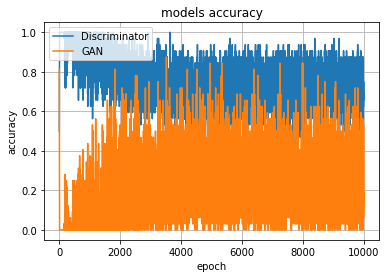

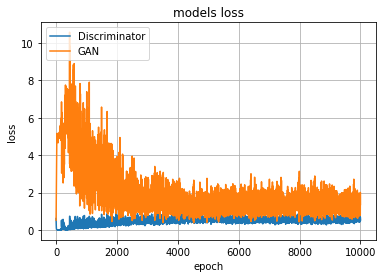

In [12]:
%%time
gan.train(X_train)

In [13]:
gan.history_D.tail()

,iter,loss,acc
9995,9995.0,0.592664,0.68750
9996,9996.0,0.688444,0.68750
9997,9997.0,0.478563,0.75000
9998,9998.0,0.616760,0.65625
9999,9999.0,0.554189,0.68750


In [14]:
gan.history_GAN.tail()

,iter,loss,acc
9995,9995.0,0.806657,0.53125
9996,9996.0,1.268234,0.12500
9997,9997.0,2.011892,0.06250
9998,9998.0,1.713208,0.15625
9999,9999.0,1.364804,0.18750


In [15]:
gen_noise = np.random.normal(0, 1, (16,100))

In [16]:
gen_noise.shape

(16, 100)

In [17]:
syntetic_images = gan.G.predict(gen_noise)

In [18]:
syntetic_images.shape

(16, 28, 28, 1)

In [20]:
np.array(syntetic_images[1,:,:,0]).reshape(28*28)*127.5 + 127.5

array([2.48649383e+00, 1.74096682e+00, 1.20454061e+00, 3.16790391e-01,
       4.23409482e-01, 9.84308858e+00, 2.67557930e-01, 3.77658744e+00,
       1.02014923e+01, 1.39592118e+00, 2.88542642e+00, 4.80265237e-01,
       8.09359330e-01, 8.18353570e+00, 7.94093788e-01, 5.11440390e-01,
       1.05470684e+01, 4.55069251e-01, 3.27995961e+00, 9.91535223e-01,
       2.49372497e-01, 3.81367912e+00, 2.25628797e+00, 3.54983378e+00,
       3.74022314e-01, 7.63090057e+00, 4.21960604e+00, 2.11269053e+00,
       5.50062701e-01, 1.28437316e+00, 1.49506595e+00, 5.35207689e-01,
       4.61250842e-01, 2.24226689e+00, 6.09712760e-01, 1.72428523e+00,
       5.16830844e+01, 1.59022823e-01, 2.69201407e+00, 3.43303515e+00,
       2.76250250e-01, 2.18290562e+01, 1.66854322e+01, 6.86753637e-01,
       1.06164495e+00, 1.45300062e+00, 4.25088191e+00, 5.03924848e-01,
       6.00059873e+01, 8.21913320e-01, 1.35181685e+00, 1.12254326e+00,
       2.02486793e-01, 1.04631399e-01, 5.93648759e-01, 5.78765282e-01,
      

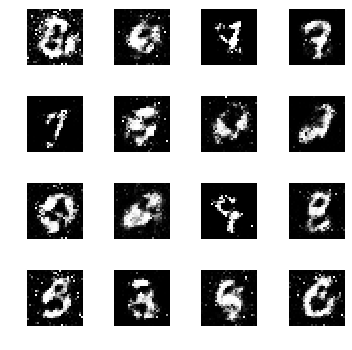

In [21]:
plt.figure(figsize=(5,5))
for i in range(syntetic_images.shape[0]):
    plt.subplot(4, 4, i+1)
    image = syntetic_images[i, :, :, :]
    image = np.reshape(image, [ gan.HEIGHT, gan.WIDTH ])
    plt.imshow(image, cmap='gray')
    plt.axis('off')
    plt.tight_layout()